Experimenting with new visualisations & features
---

---

In [1]:
from pathlib import Path
import os
_cwd = os.getcwd()

In [2]:
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()

'C:\\Users\\Giulia\\Study\\projects\\research\\SAE'

In [3]:
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

In [4]:
import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd

In [5]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [6]:
# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 

In [7]:
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from datasets import synth_dataset 
import visualisations
from visualisations import visualise_data, visualise_model

In [8]:
import importlib
importlib.reload(experiments)
importlib.reload(sns)

importlib.reload(metrics)
importlib.reload(datasets)
importlib.reload(models)
importlib.reload(EvaluationManager)
importlib.reload(score_disentanglement)
importlib.reload(visualise_data)

<module 'visualisations.visualise_data' from 'C:\\Users\\Giulia\\Study\\projects\\research\\SAE\\visualisations\\visualise_data.py'>

In [ ]:
handler = VectorModelHandler(model_name="VecESAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

In [40]:
big_handler = VectorModelHandler(model_name="VecESAE", model_version="standard", data="SynthVec", data_version="big", verbose=False)

Loading VecESAE
--------------------
----------Opening SynthVec dataset version big / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Writing quantiles file
Dataset loaded.
----------Opening SynthVec dataset version big / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model loaded.


In [19]:
checkpoints = handler.list_available_checkpoints()

Available checkpoints at \cluster\scratch\glanzillo\logs\VecESAE\standard_SynthVec_standard\checkpoints :
[]


In [20]:
handler.load_checkpoint()

No checkpoint available at \cluster\scratch\glanzillo\logs\VecESAE\standard_SynthVec_standard\checkpoints. Cannot load trained weights.


## Plotting Synthetic Vector dataset

Inspiration from https://github.com/derekbanas/seaborn/blob/master/SB%20Tut.ipynb

Loading generated data.
Loading metadata


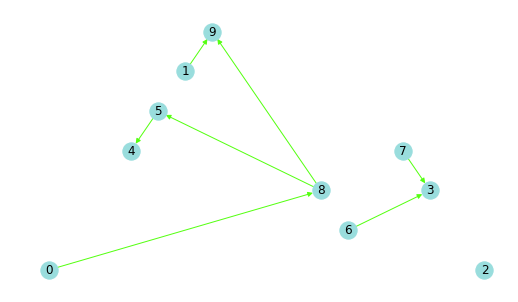

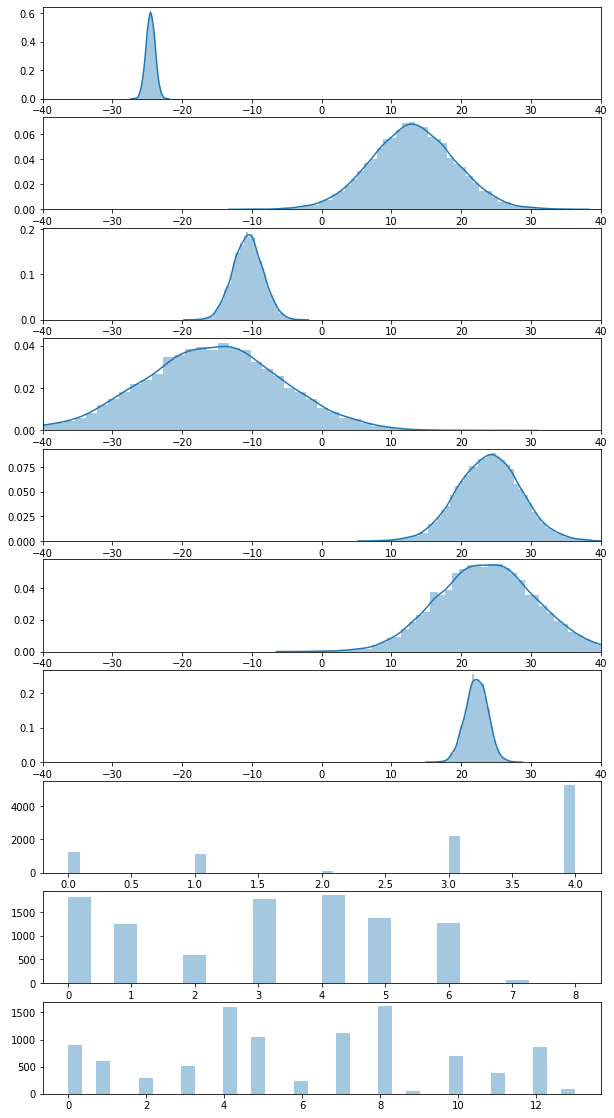

<Figure size 720x1440 with 0 Axes>

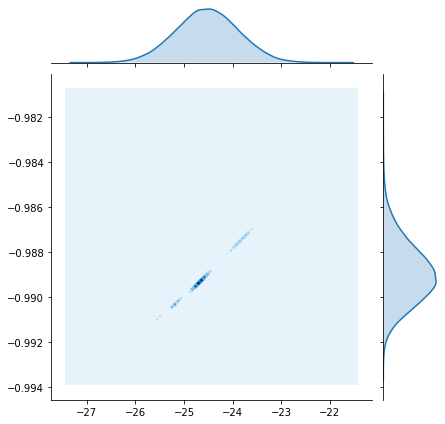

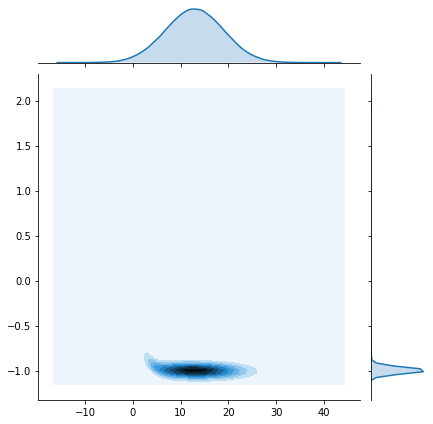

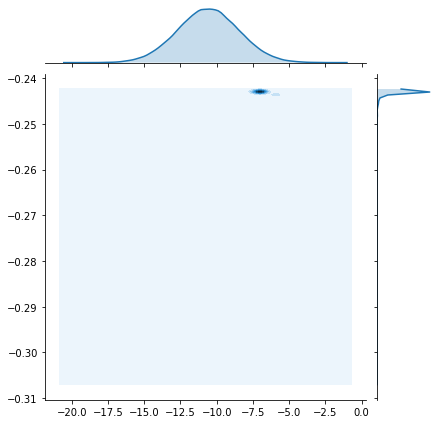

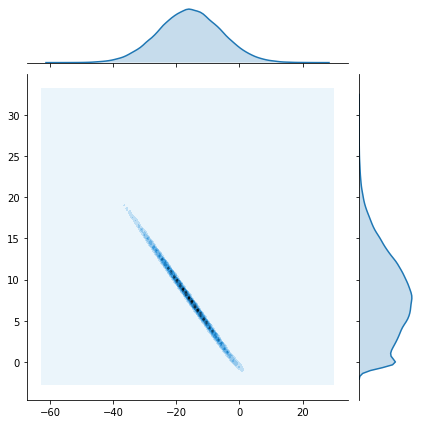

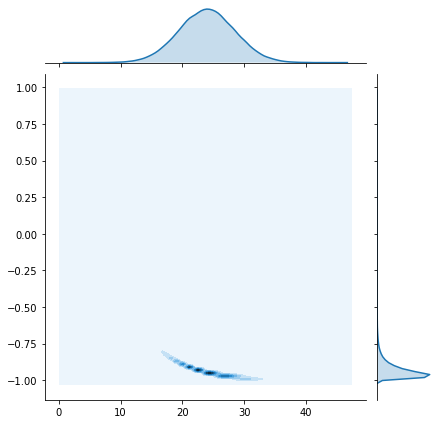

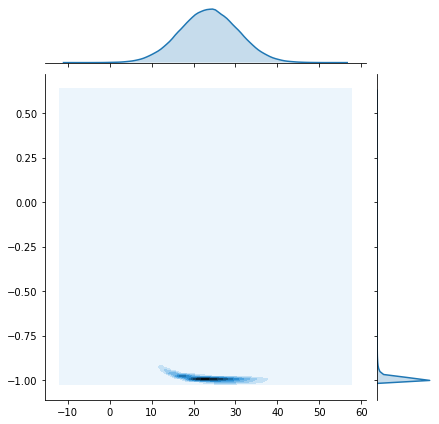

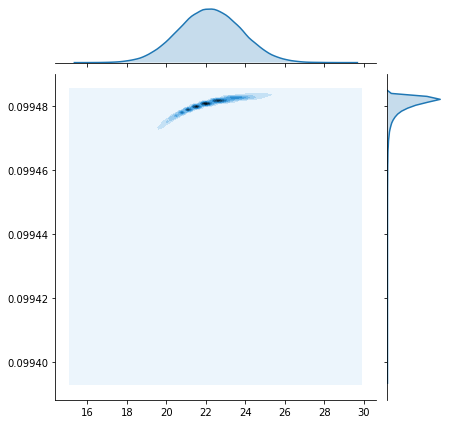

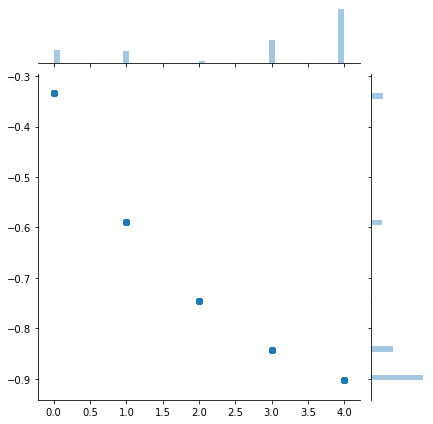

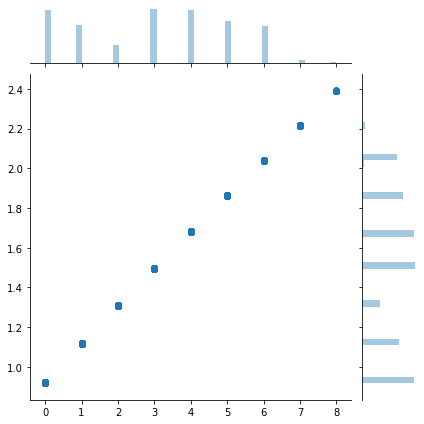

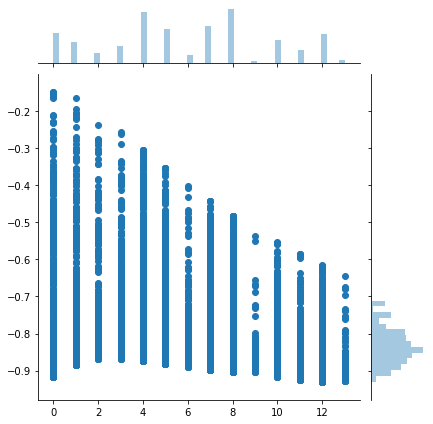

In [44]:
handler.plot_data()

---

In [9]:
handler = VectorModelHandler(model_name="VecESAE", model_version="standard", data="SynthVec", data_version="continuous", verbose=False)

Loading VecESAE
--------------------
----------Opening SynthVec dataset version continuous / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version continuous / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model loaded.


In [10]:
train = handler.dataloader.train.dataset.dataset
test = handler.dataloader.test.dataset
print(train)

Dataset SynthVec info
  Size = 100000
  Factors of variation : 
  factor7_continuous with 20 values
  factor6_continuous with 20 values
  factor3_continuous with 20 values
  factor2_continuous with 20 values
  factor1_continuous with 20 values
  factor0_continuous with 20 values
  factor8_continuous with 20 values
  factor9_continuous with 20 values
  factor5_continuous with 20 values
  factor4_continuous with 20 values


In [11]:
np.mean(train.original_labels, axis=0)

array([-0.32932007,  1.1844516 , -0.7381415 , -0.970897  ,  1.8038777 ,
        1.0072279 , -0.9963445 , -0.9894092 ,  0.9797089 ,  7.124151  ],
      dtype=float32)

In [12]:
np.std(train.original_labels, axis=0)

array([0.03085204, 0.8230602 , 0.00796466, 0.27207574, 0.30160248,
       1.8051283 , 0.06516504, 0.15977217, 1.0207767 , 6.9742756 ],
      dtype=float32)

In [38]:
np.unique(train.original_labels[:,7]).shape

(2076,)

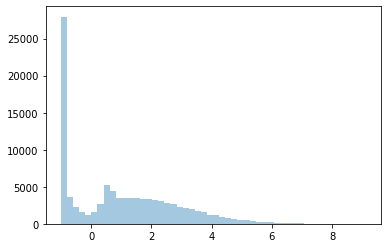

In [31]:
sns.distplot(train.original_labels[:,5], kde=False) # very low std 

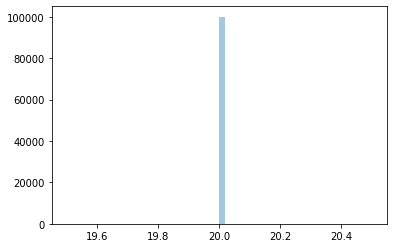

In [33]:
sns.distplot(train.labels[:,7], kde=False)

In [16]:
test = handler.dataloader.test.dataset
print(test)

Dataset SynthVec info
  Size = 2000
  Factors of variation : 
  factor7_continuous with 20 values
  factor6_continuous with 20 values
  factor3_continuous with 20 values
  factor2_continuous with 20 values
  factor1_continuous with 20 values
  factor0_continuous with 20 values
  factor8_continuous with 20 values
  factor9_continuous with 20 values
  factor5_continuous with 20 values
  factor4_continuous with 20 values


In [17]:
np.mean(test.original_labels, axis=0)

array([-0.32922027,  1.1817259 , -0.7382262 , -0.9657789 ,  1.8005868 ,
        1.0294529 , -0.99673855, -0.9911658 ,  0.9683738 ,  6.9910493 ],
      dtype=float32)

In [18]:
np.std(test.original_labels, axis=0)

array([0.03207096, 0.8300561 , 0.00817994, 0.297848  , 0.3125329 ,
       1.7791648 , 0.06426879, 0.15023856, 1.0292307 , 6.9105215 ],
      dtype=float32)

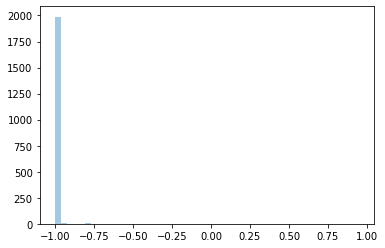

In [19]:
sns.distplot(test.original_labels[:,6], kde=False) # very low std 

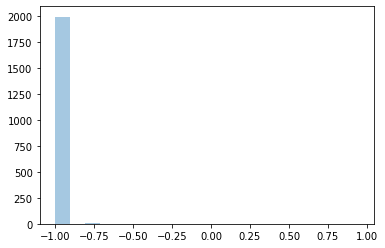

In [20]:
sns.distplot(test.original_labels[:,6], kde=False, bins=20)

In [21]:
X1,Y1,N1,X2,Y2,N2,metadata = train.read_source_files()

Loading generated data.
Loading metadata


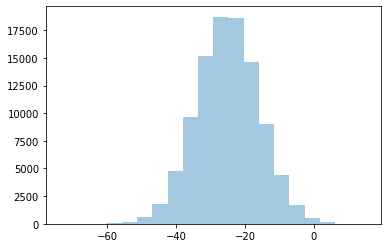

In [39]:
sns.distplot(N1[:,7], kde=False, bins=20)

In [23]:
equations = train.metadata["equations"]
ancestors = train.metadata["node_ancestors"]
node_order = train.metadata["node_order"]
samplers = train.metadata["samplers"]

In [24]:
samplers

[Normal(loc: tensor([17.2347]), scale: tensor([5.3741])),
 Normal(loc: tensor([23.1260]), scale: tensor([7.8631])),
 Normal(loc: tensor([4.0526]), scale: tensor([5.4626])),
 Normal(loc: tensor([-5.7362]), scale: tensor([1.8159])),
 Normal(loc: tensor([-4.9027]), scale: tensor([10.0343])),
 Normal(loc: tensor([10.5288]), scale: tensor([7.9602])),
 Normal(loc: tensor([-16.5790]), scale: tensor([1.2984])),
 Normal(loc: tensor([-0.6550]), scale: tensor([9.7673])),
 Normal(loc: tensor([1.7523]), scale: tensor([1.4865])),
 Normal(loc: tensor([7.8328]), scale: tensor([5.3220]))]

In [22]:
node_order

[7, 6, 3, 2, 1, 0, 8, 9, 5, 4]

In [35]:
ancestors

[[], [], [6, 7], [], [], [], [0], [1, 8], [8], [5]]

In [43]:
equations[2]

FCBlock(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=1, out_features=1, bias=True)
    (3): ELU(alpha=1.0)
  )
)

---

In [40]:
graph_adj = train.get_graph_matrix()
graph_adj

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [41]:
import networkx as nx

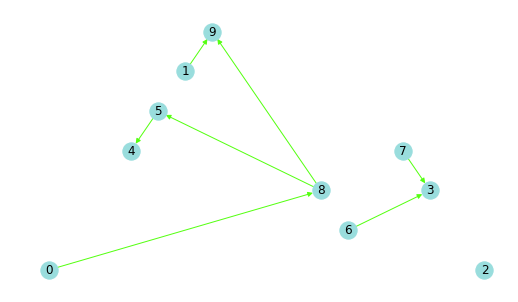

In [42]:
figure = plt.figure(figsize=(7,4))
nx.draw(train.metadata["graph"], with_labels=True, 
        node_size=300, node_color="#99dddd", 
        edge_color="#55ff11", pos=nx.planar_layout(train.metadata["graph"])) 
#this could be a good plot to show 

In [11]:
train.noise 

False

In [12]:
np.std(train.original_labels, axis=0)

array([1.8710884e+00, 1.2637746e+00, 1.2551561e-01, 4.3090653e-01,
       5.7017908e-04, 6.7534663e-02, 4.5978621e-01, 4.5136356e-01,
       8.3747305e-02, 9.9162328e-01], dtype=float32)

In [26]:
samplers = train.metadata["samplers"] # maybe plot this - for each dimension its distribution
samplers

[Normal(loc: tensor([3.8419]), scale: tensor([7.9243])),
 Normal(loc: tensor([0.5168]), scale: tensor([7.3244])),
 Normal(loc: tensor([10.0420]), scale: tensor([0.3098])),
 Normal(loc: tensor([23.6192]), scale: tensor([2.8227])),
 Normal(loc: tensor([-2.7236]), scale: tensor([5.4246])),
 Normal(loc: tensor([17.7461]), scale: tensor([0.4316])),
 Normal(loc: tensor([14.2108]), scale: tensor([0.0048])),
 Categorical(probs: torch.Size([6])),
 Categorical(probs: torch.Size([12])),
 Categorical(probs: torch.Size([5]))]

In [ ]:
equations = train.metadata["equations"]
discrete = train.metadata["discrete"]

In [ ]:
colors = ["blue", 'orange', 'green', 'red', 'purple', 'cyan', 'brown', 'pink', 'gray', 'olive']

In [ ]:
fig, axs = plt.subplots(nrows=len(samplers), figsize=(10,20))
for i in range(len(samplers)):
    if discrete[i]:
        sns.distplot(samplers[i].sample([10000]), ax = axs[i], kde=False)
    else:
        axs[i].set_xlim(-40,40)
        sns.distplot(samplers[i].sample([10000]), ax = axs[i])

In [ ]:
# one plot could be showing noise VS causal variables 

In [ ]:
X1,Y1,N1,X2,Y2,N2,metadata = train.read_source_files()

In [ ]:
#fig, axs = plt.subplots(nrows=len(samplers), figsize=(10,20))
for i in range(len(samplers)):
    sns.jointplot(N1[:,i], Y1[:,i], kind="kde")

In [ ]:
# one plot could be showing only the causal variables and their relationships 

In [ ]:
y_df = pd.DataFrame(y)

In [ ]:
sns.pairplot(y_df)

In [ ]:
sns.pairplot(y_df, kind="kde", corner=True)

In [ ]:
# one plot could be showing just the observables 

In [ ]:
train.data.shape

## Testing Evaluation Manager new features

In [ ]:
#handler.model.cpu()
scores = handler.score_model(FID=False, disentanglement=True, orthogonality=True)

In [ ]:
scores

In [ ]:
scores['extra_disentanglement'] =None

In [ ]:
import json
base_path = Path(handler.config['logging_params']['save_dir']) / \
                        handler.config['logging_params']['name'] / \
                        handler.config['logging_params']['version'] / "scoring.json"
with open(base_path, 'w') as o:
    json.dump(scores, o)

In [ ]:
plots = handler.plot_model(do_originals=True, do_reconstructions=True, do_random_samples=True, do_traversals=True)

In [ ]:
plots["random_samples"]

---

In [8]:
handler = VisualModelHandler(model_name="BaseSAE", model_version="standardS", data="MNIST")

configs/models/BaseSAE/standardS.yaml
Loading BaseSAE
--------------------
BaseSAE model loaded.


In [9]:
handler.load_checkpoint()

Loading latest checkpoint at logs\BaseSAE\standardS_MNIST\checkpoints\epoch=292-step=95976.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
             Mish-12             [-1, 32, 7, 7]        

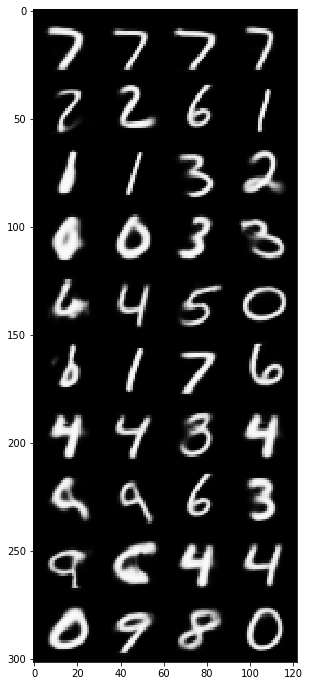

In [10]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
#fname = fig_path / "hybridsLowSae.png"
#fig.savefig(fname)

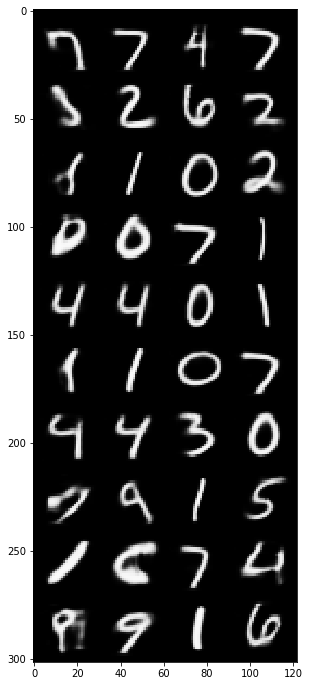

In [11]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
#fname = fig_path / "hybridsHighSae.png"
#fig.savefig(fname)

In [12]:
handlerESAE = VisualModelHandler(model_name="ESAE", model_version="standardS", data="MNIST")

configs/models/ESAE/standardS.yaml
Loading ESAE
--------------------
ESAE model loaded.


In [13]:
handlerESAE.load_checkpoint()

Loading latest checkpoint at logs\ESAE\standardS_MNIST\checkpoints\epoch=178-step=58761.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
        MaxPool2d-11             [-1, 32, 7, 7]               0
             Mish-12             [-1, 32, 7, 7]           

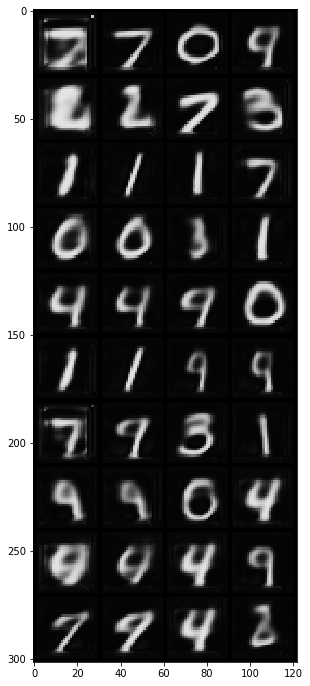

In [14]:
res = handlerESAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
#fname = fig_path / "hybridsLowESAE.png"
#fig.savefig(fname)

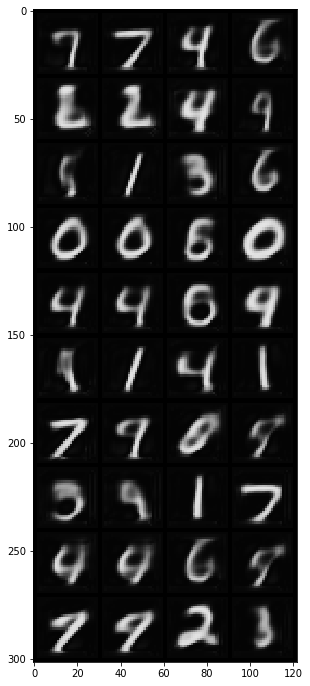

In [15]:
res = handlerESAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
#fname = fig_path / "hybridsHighESAE.png"
#fig.savefig(fname)

In [16]:
handlerVAE = VisualModelHandler(model_name="BetaVAE", model_version="standard", data="MNIST")
handlerVAE.load_checkpoint()

Loading BetaVAE
--------------------
BetaVAE model loaded.
Loading latest checkpoint at logs\BetaVAE\standard_MNIST\checkpoints\final.ckpt .
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
         MaxPool2d-2           [-1, 64, 14, 14]               0
              Mish-3           [-1, 64, 14, 14]               0
       BatchNorm2d-4           [-1, 64, 14, 14]             128
         ConvBlock-5           [-1, 64, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          36,928
              Mish-7           [-1, 64, 14, 14]               0
       BatchNorm2d-8           [-1, 64, 14, 14]             128
         ConvBlock-9           [-1, 64, 14, 14]               0
           Conv2d-10           [-1, 64, 14, 14]          36,928
        MaxPool2d-11             [-1, 64, 7, 7]               0
            

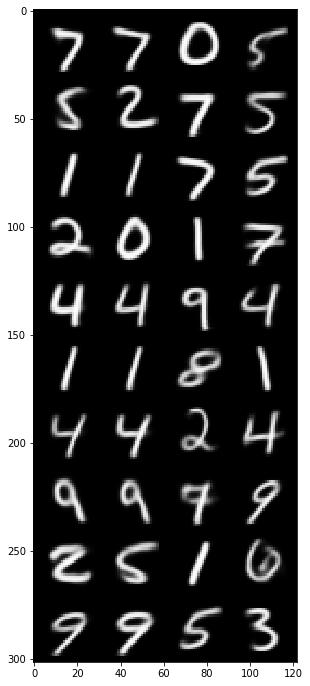

In [17]:
res = handlerVAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=True)
fig = res['hybrids']
#fname = fig_path / "hybridsHighVAE.png"
#fig.savefig(fname)

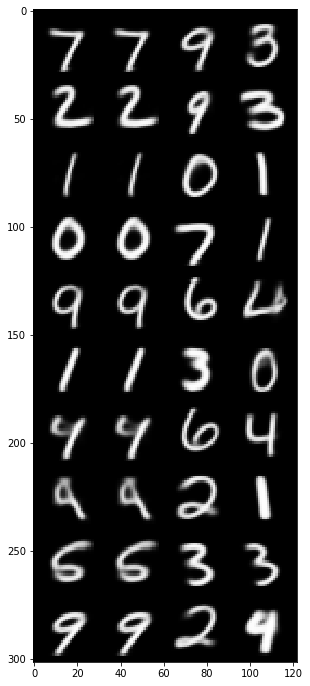

In [21]:
res = handlerVAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_hybrisation=True, first=False)
fig = res['hybrids']
fname = fig_path / "hybridsLowVAE.png"
fig.savefig(fname)

---

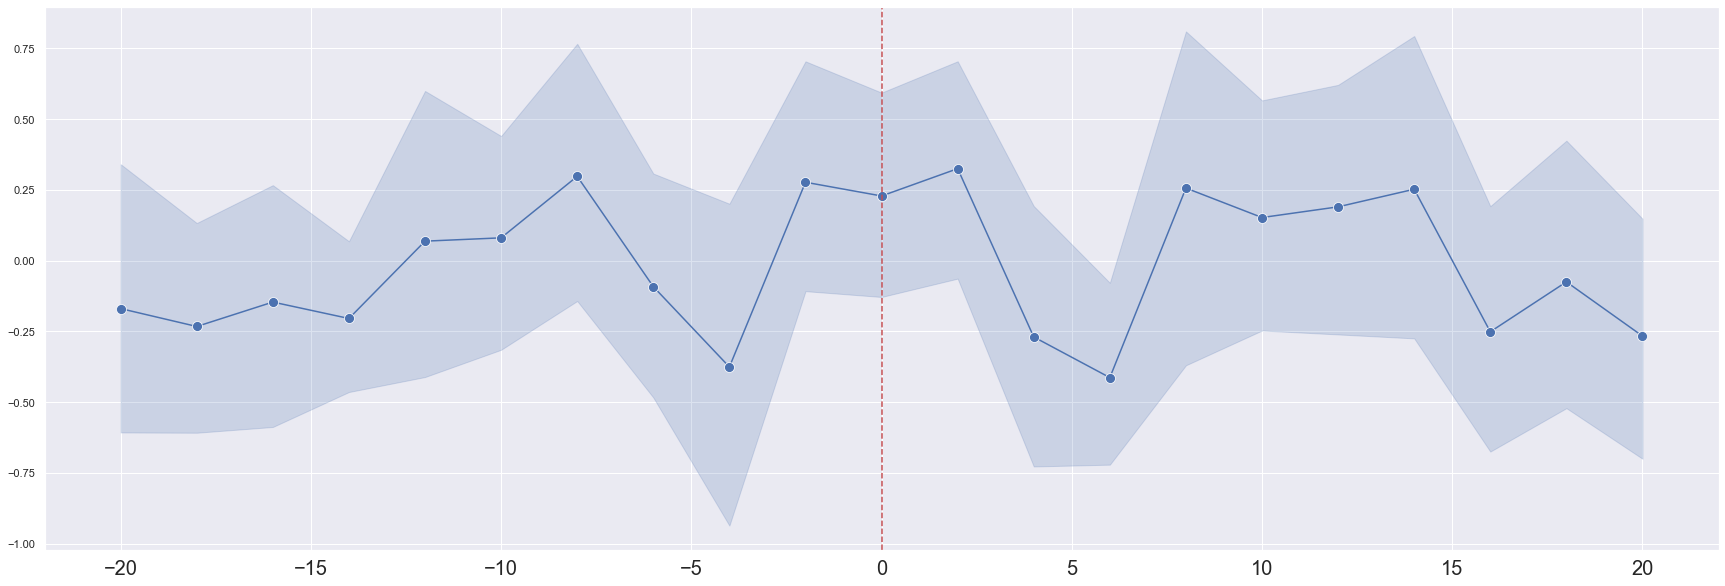

In [20]:
figure = plt.figure(figsize=(30,10))
N=21
dist = np.linspace(-20,20,21)
Nlosses = np.random.randn(N,21)
ax = sns.lineplot(np.tile(dist, N), Nlosses.reshape(-1,), marker=".", markersize=20)
ax.tick_params(axis="x", labelsize=20) 
plt.axvline(0, color='r', linestyle="--")

[(0, 30)]

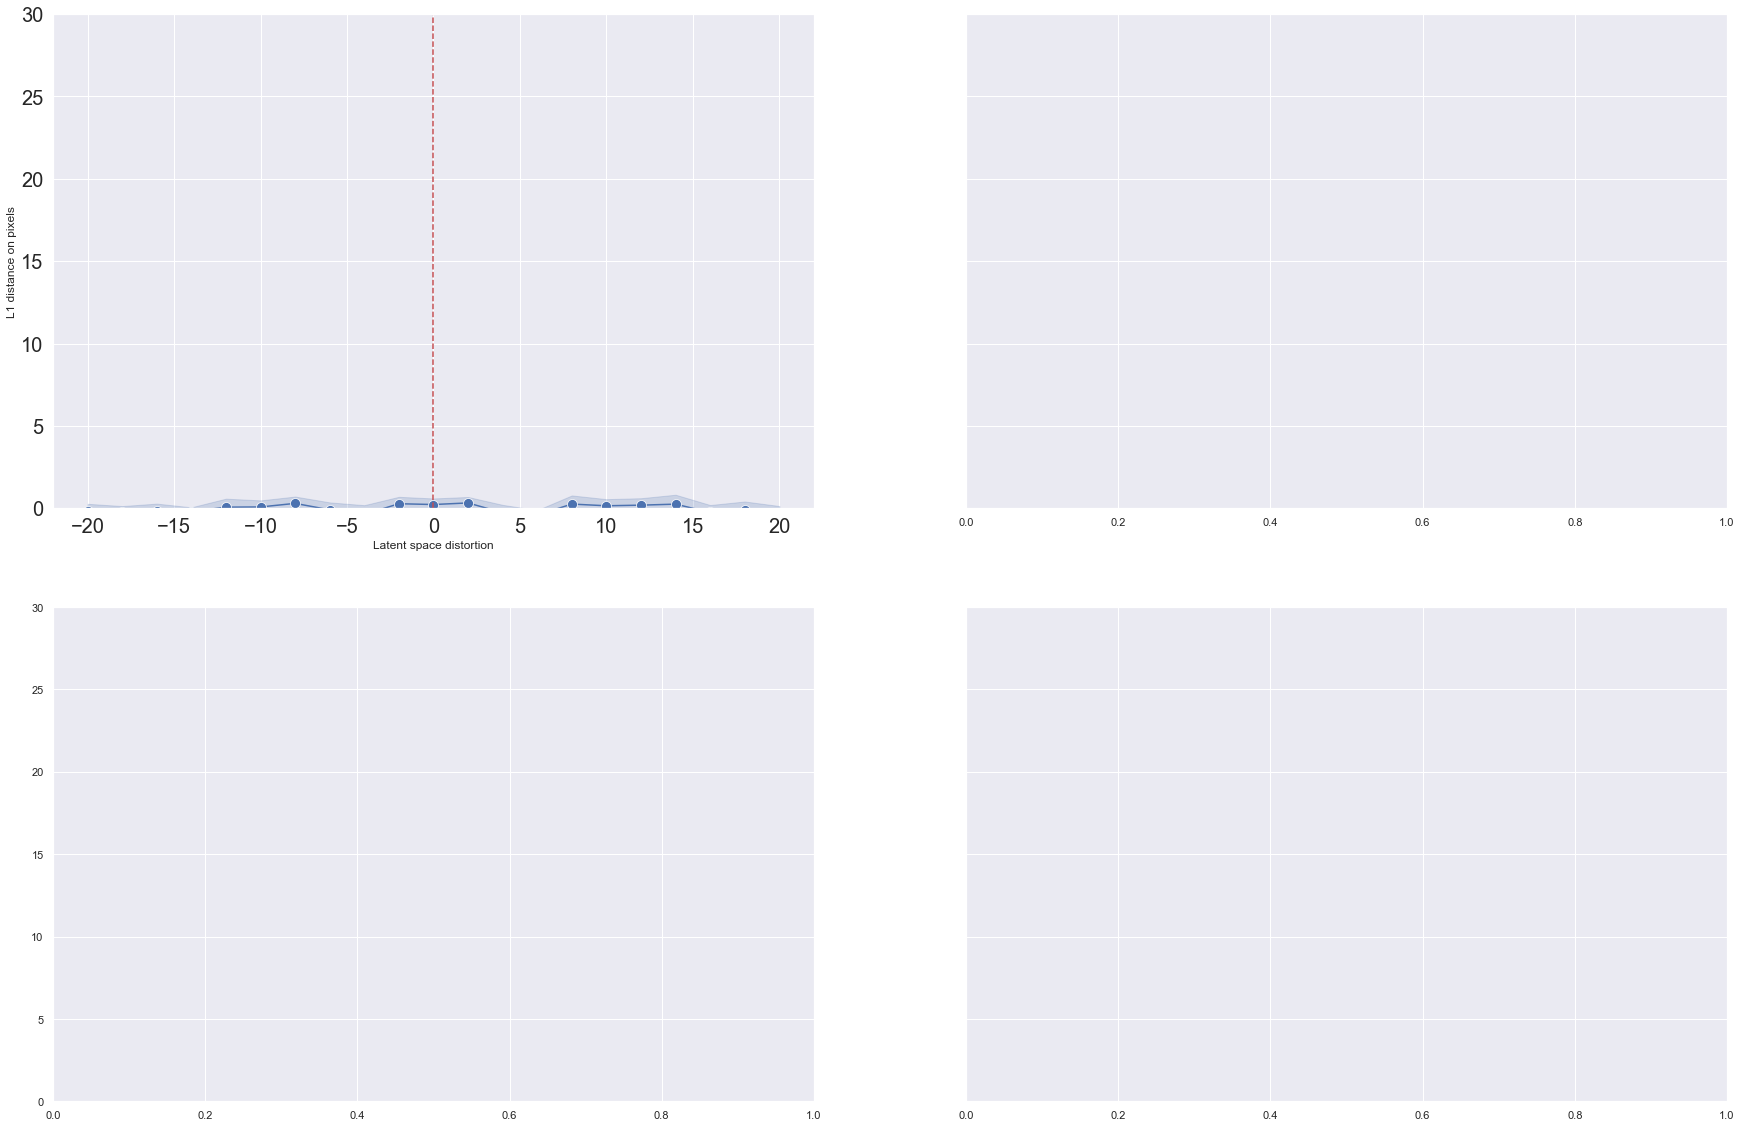

In [22]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(30,20))
sns.set(font_scale = 1)
axi=sns.lineplot(np.tile(dist, N), Nlosses.reshape(-1,), marker=".", markersize=20, ax= ax[0,0])
ax[0,0].axvline(0, color='r', linestyle="--")
axi.set(ylabel='L1 distance on pixels', xlabel='Latent space distortion')
axi.tick_params(axis="x", labelsize=20) 
axi.tick_params(axis="y", labelsize=20) 

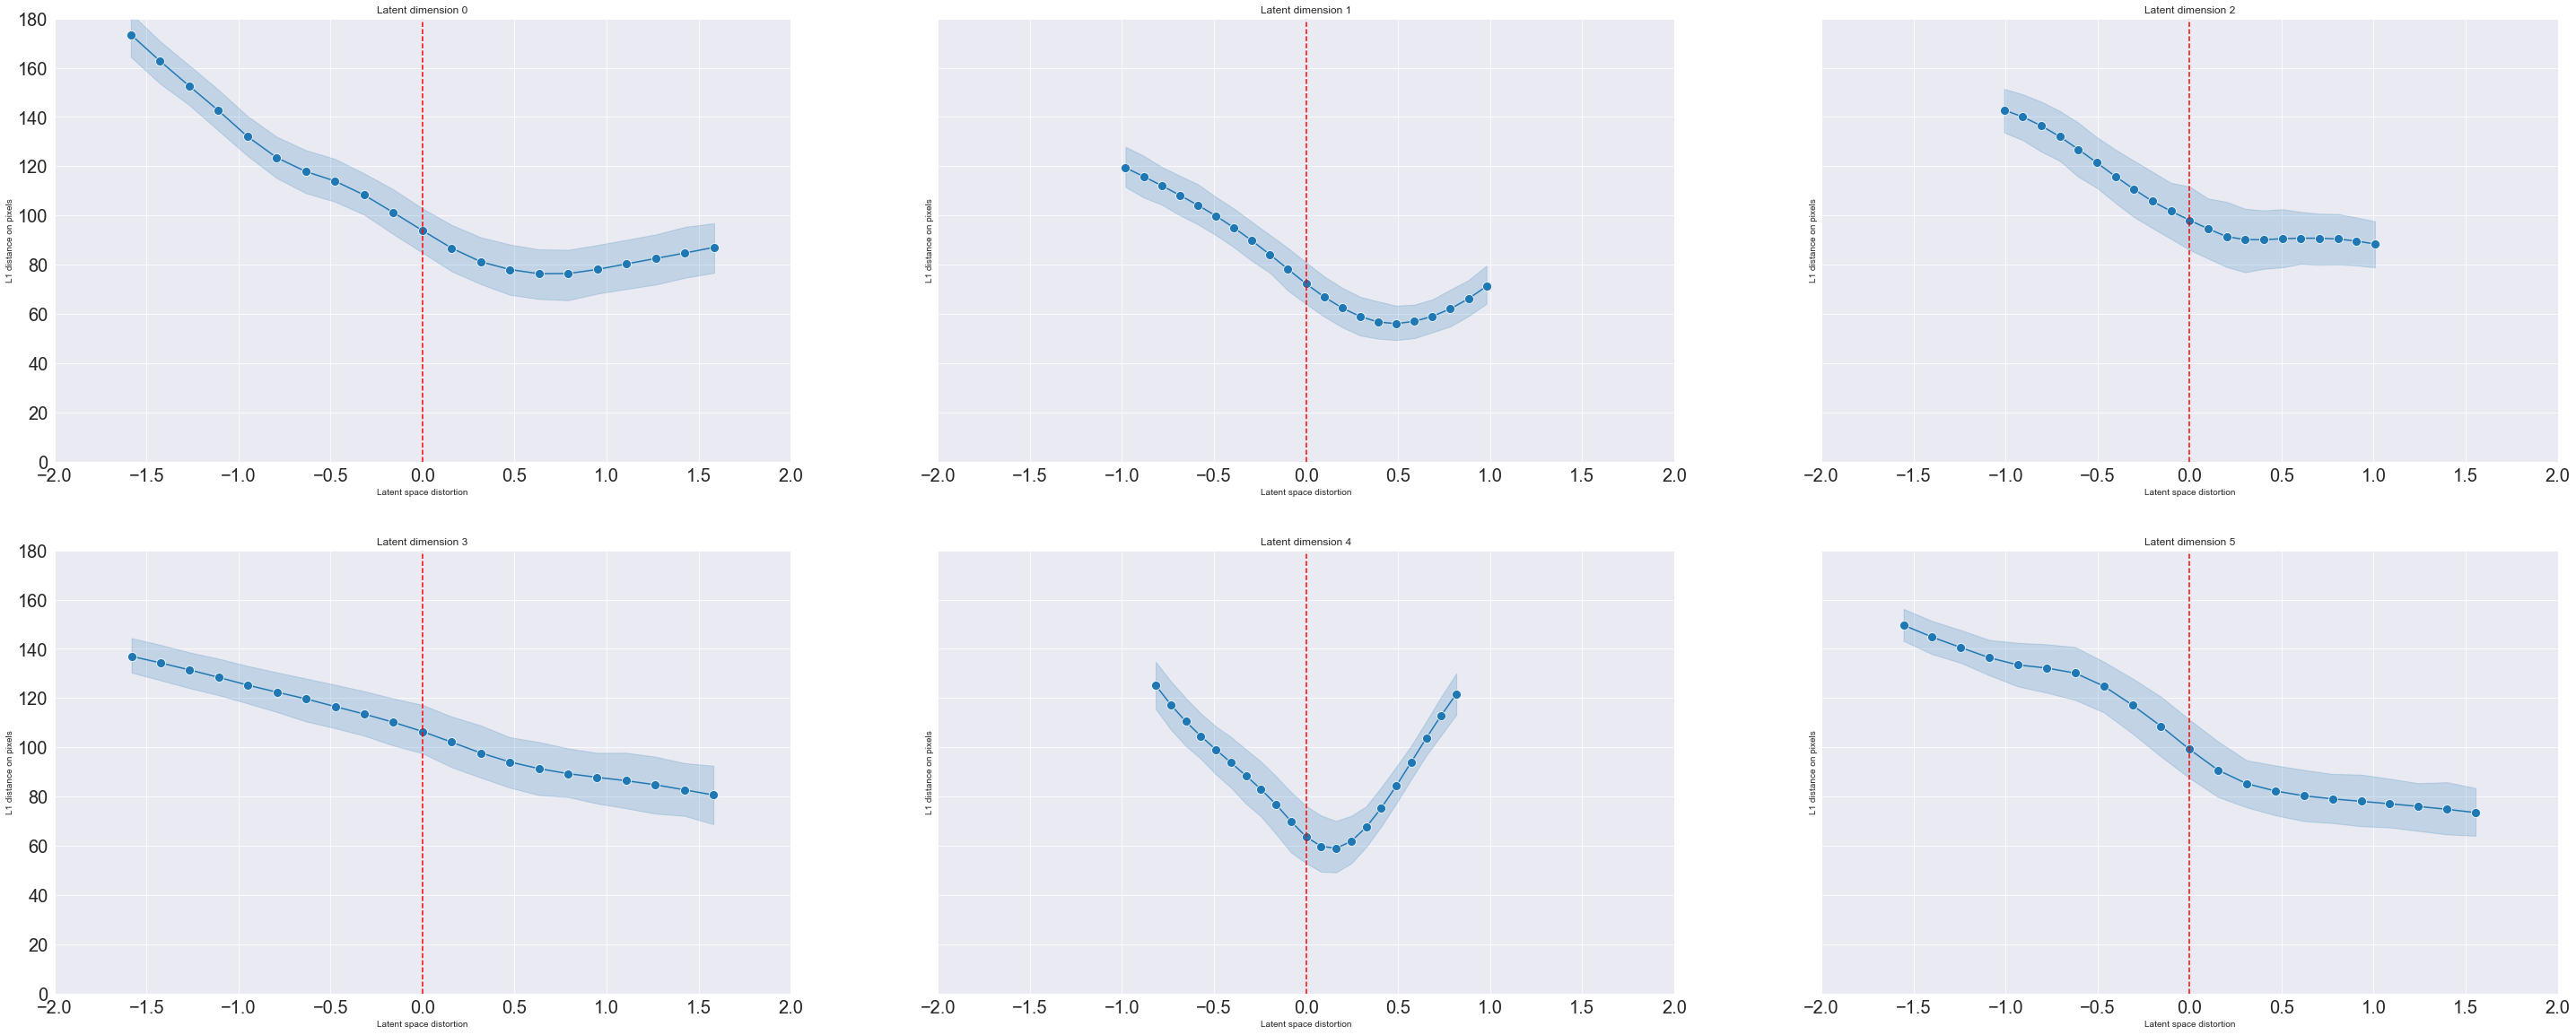

In [18]:
res = handler.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                         figsize=(50,20), nrows=2, ylim=180, xlim=2)
fig = res['distortion']
#fname = fig_path / "distortionSAE.png"
#fig.savefig(fname)

In [19]:
res = handlerESAE.plot_model(do_originals=False, do_reconstructions=False,
                   do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                             figsize=(50,20), nrows=2, ylim=180, xlim=2)
fig = res['distortion']
#fname = fig_path / "distortionESAE.png"
#fig.savefig(fname)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

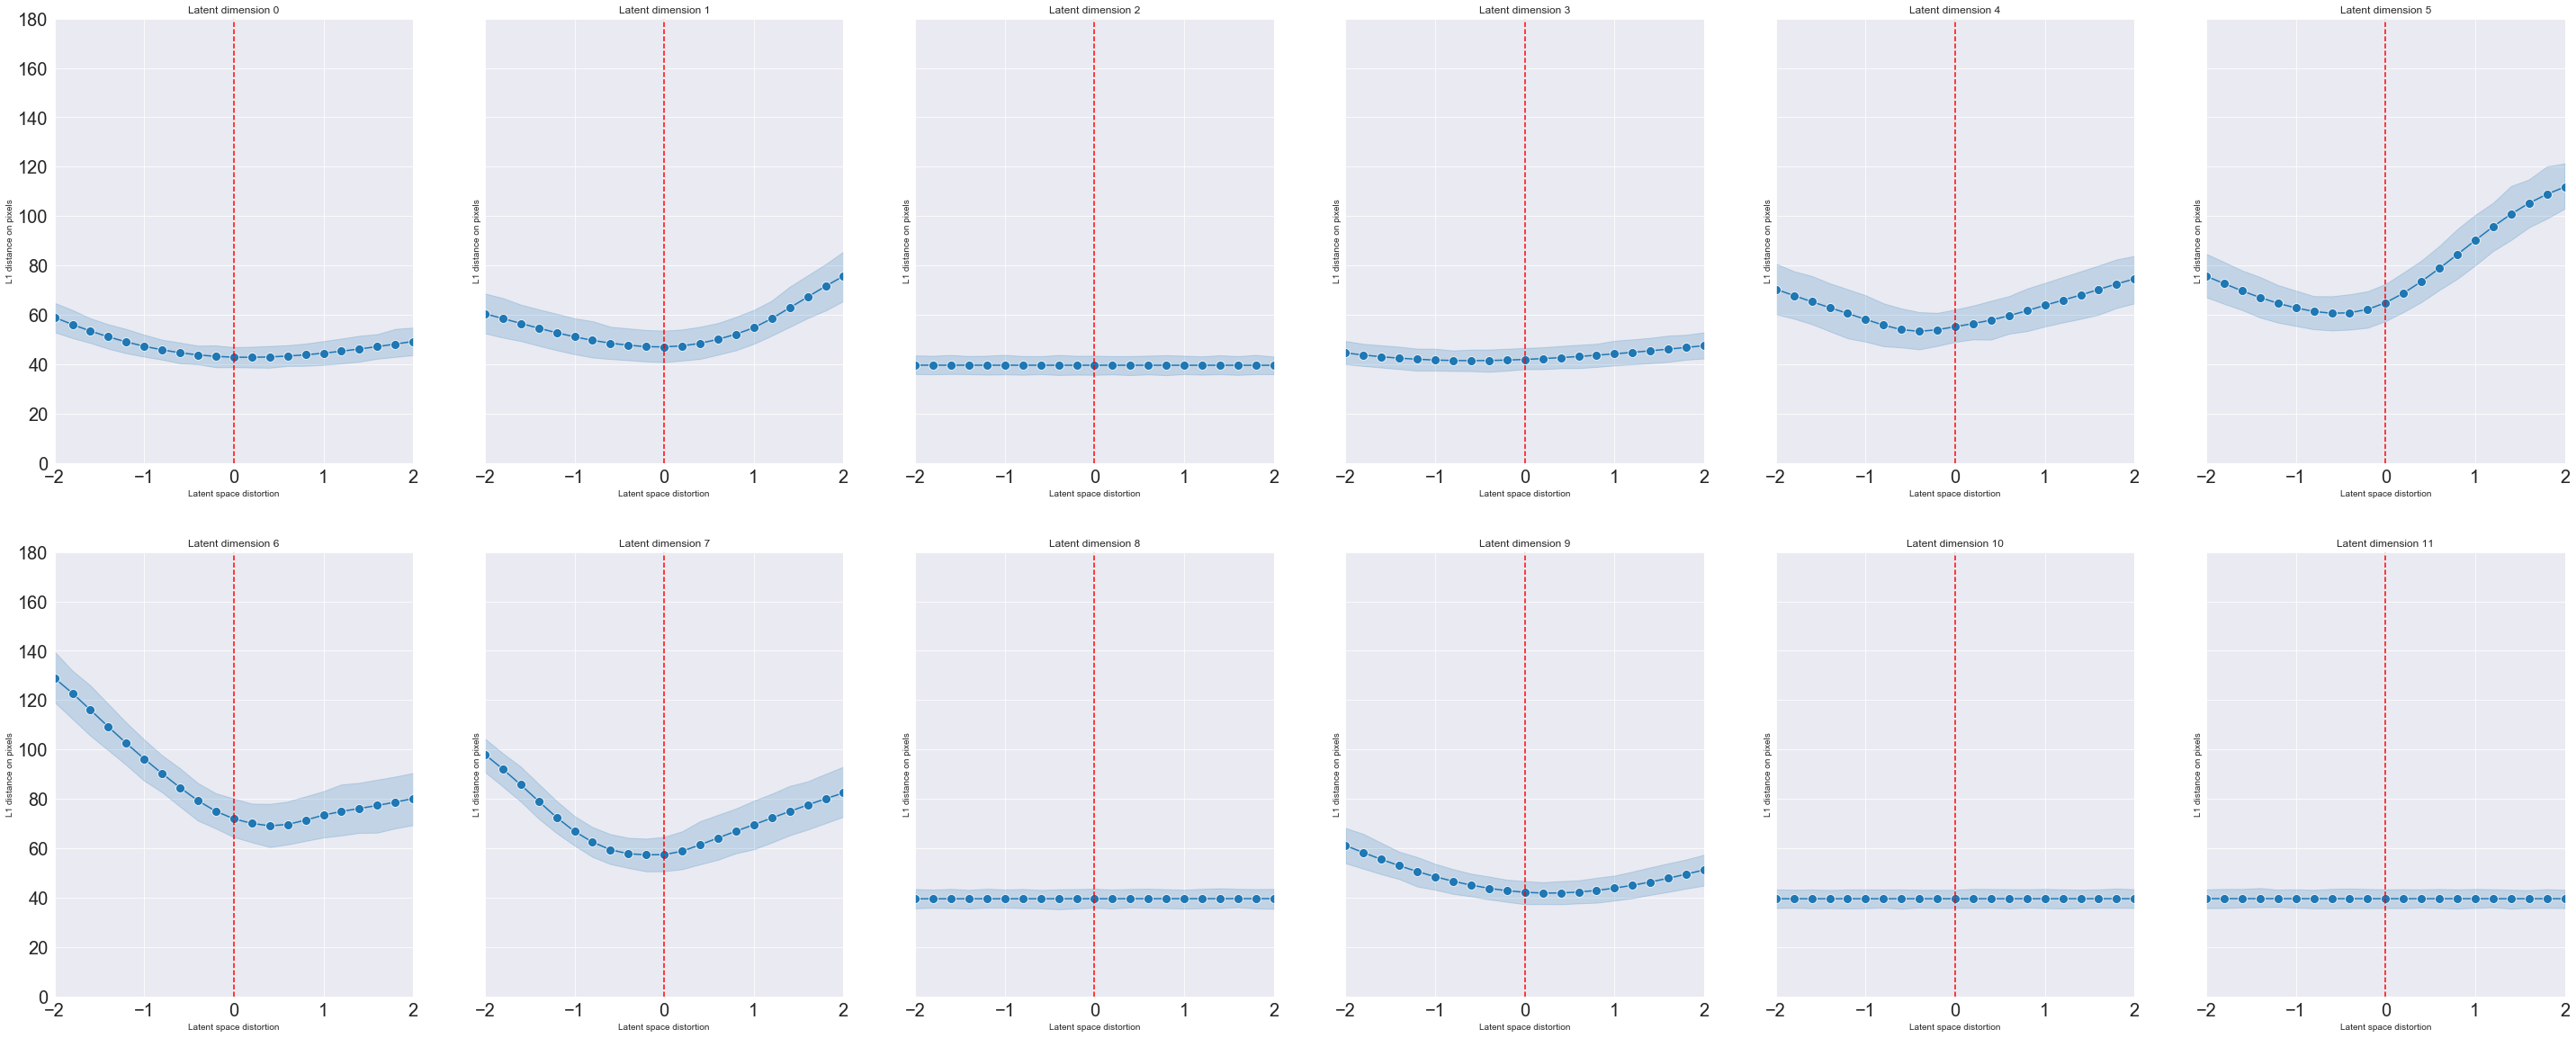

In [20]:
res = handlerVAE.plot_model(do_originals=False, do_reconstructions=False,
                            do_random_samples=False, do_traversals=False, do_loss2distortion=True, 
                            figsize=(50,20), nrows=2, font_scale=20, ylim=180, xlim=2)
fig = res['distortion']
#fname = fig_path / "distortionVAE.png"
#fig.savefig(fname)

In [8]:
vecSAE_handler = VectorModelHandler(model_name="VecSAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

Loading VecSAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecSAE model loaded.


In [9]:
vecSAE_handler.load_checkpoint()

Loading latest checkpoint at logs\VecSAE\standard_SynthVec_standard\checkpoints\final.ckpt .
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
         LeakyReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 77]           7,777
         LeakyReLU-4                   [-1, 77]               0
            Linear-5                   [-1, 55]           4,290
         LeakyReLU-6                   [-1, 55]               0
            L

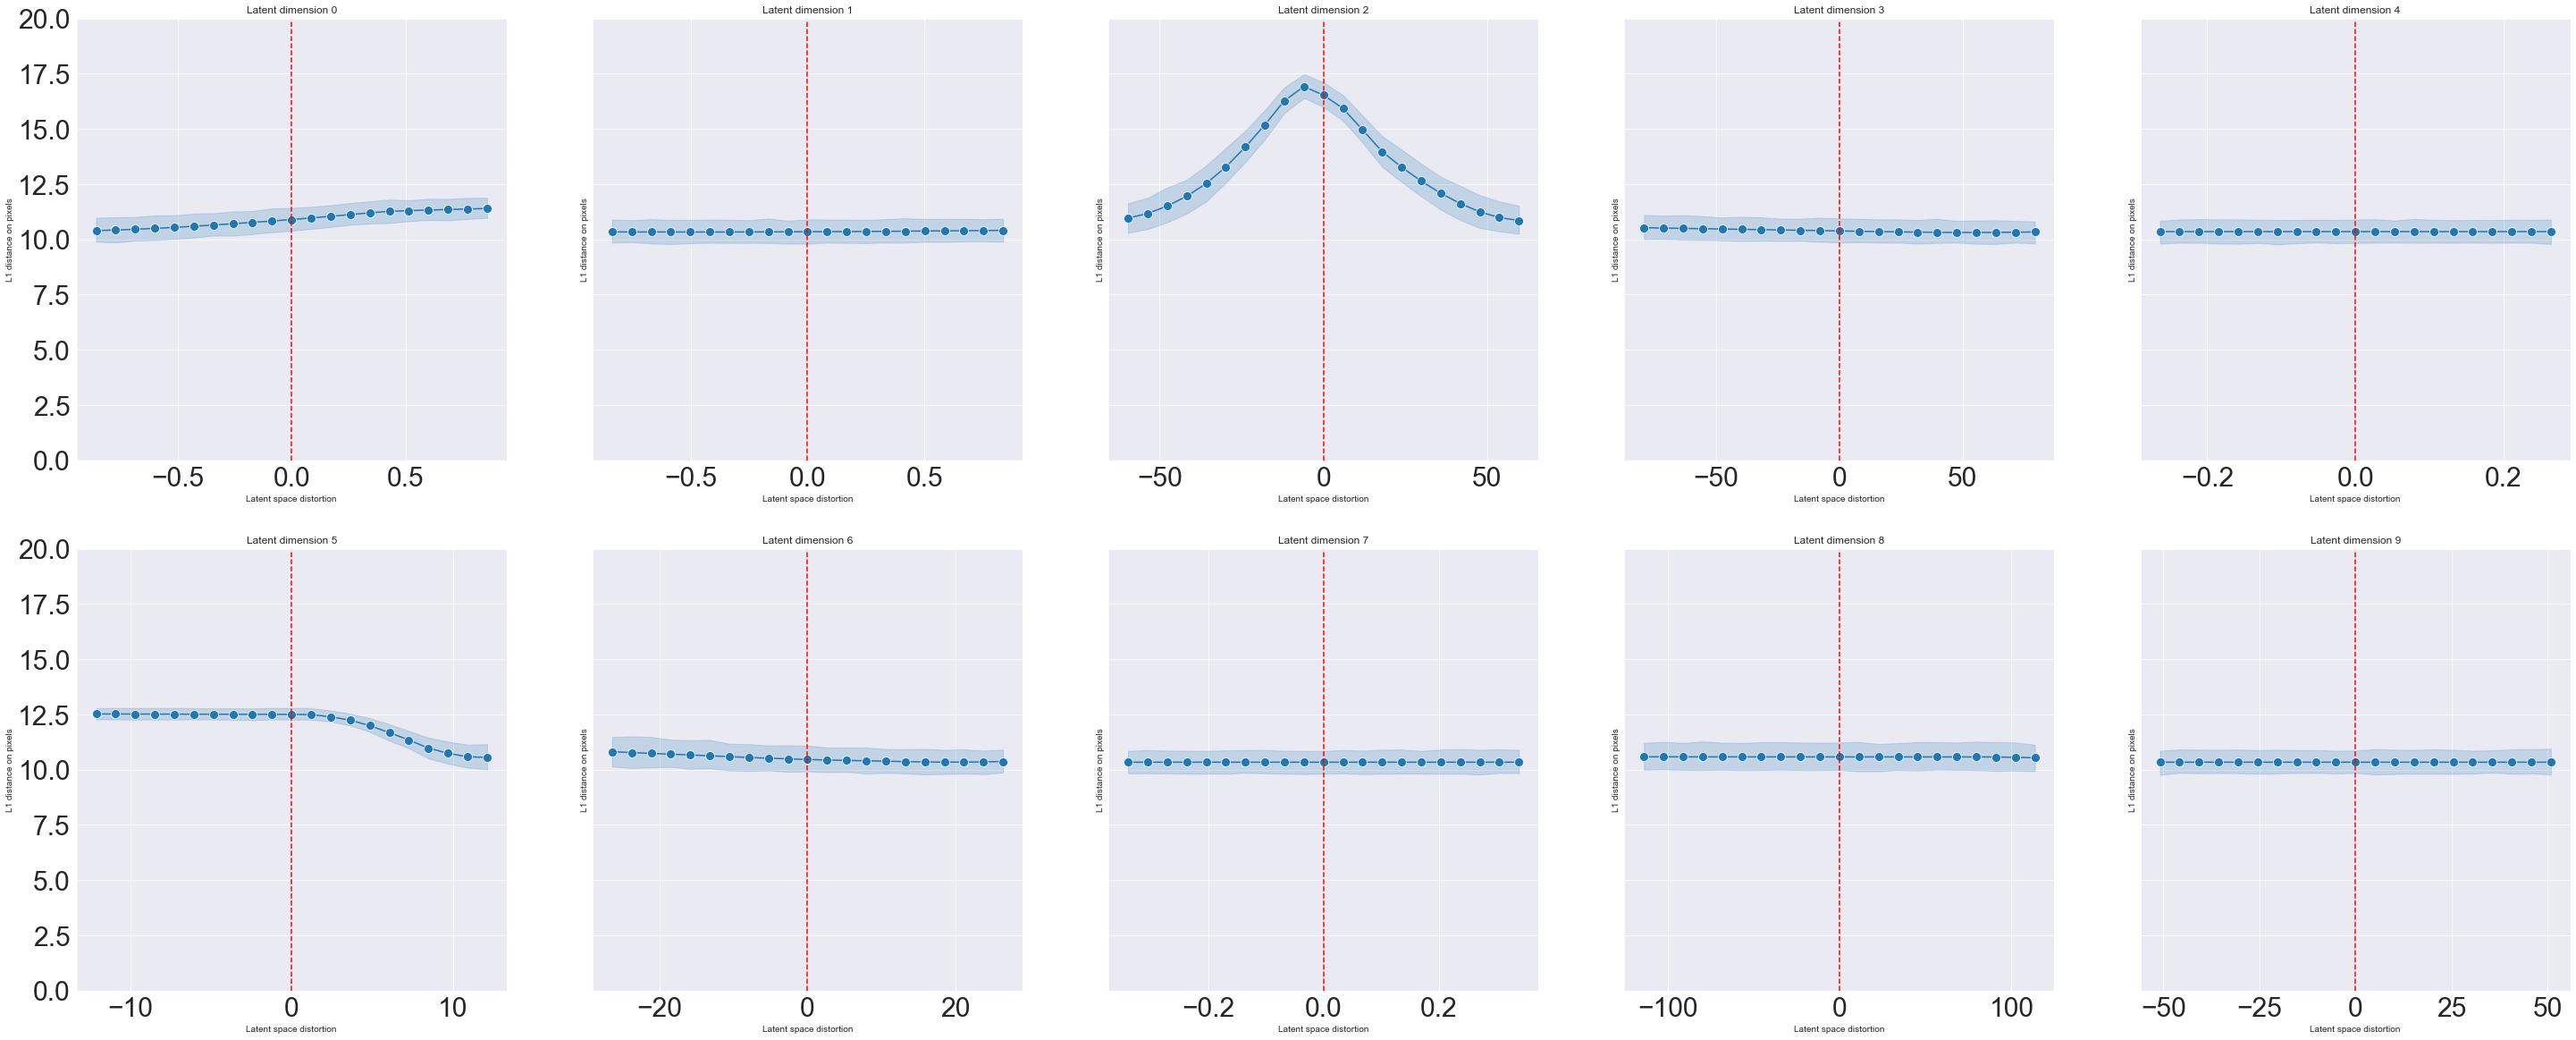

In [14]:
res = vecSAE_handler.plot_model(figsize=(50,20), nrows=2, ylim=20, font_scale=30)
fig = res['distortion']
fname = fig_path / "distortionVecSAE.png"
fig.savefig(fname)

In [12]:
vecESAE_handler = VectorModelHandler(model_name="VecESAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

Loading VecESAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model loaded.


In [13]:
vecESAE_handler.load_checkpoint()

Loading latest checkpoint at logs\VecESAE\standard_SynthVec_standard\checkpoints\final.ckpt .
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
         LeakyReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 77]           7,777
         LeakyReLU-4                   [-1, 77]               0
            Linear-5                   [-1, 55]           4,290
         LeakyReLU-6                   [-1, 55]               0
            

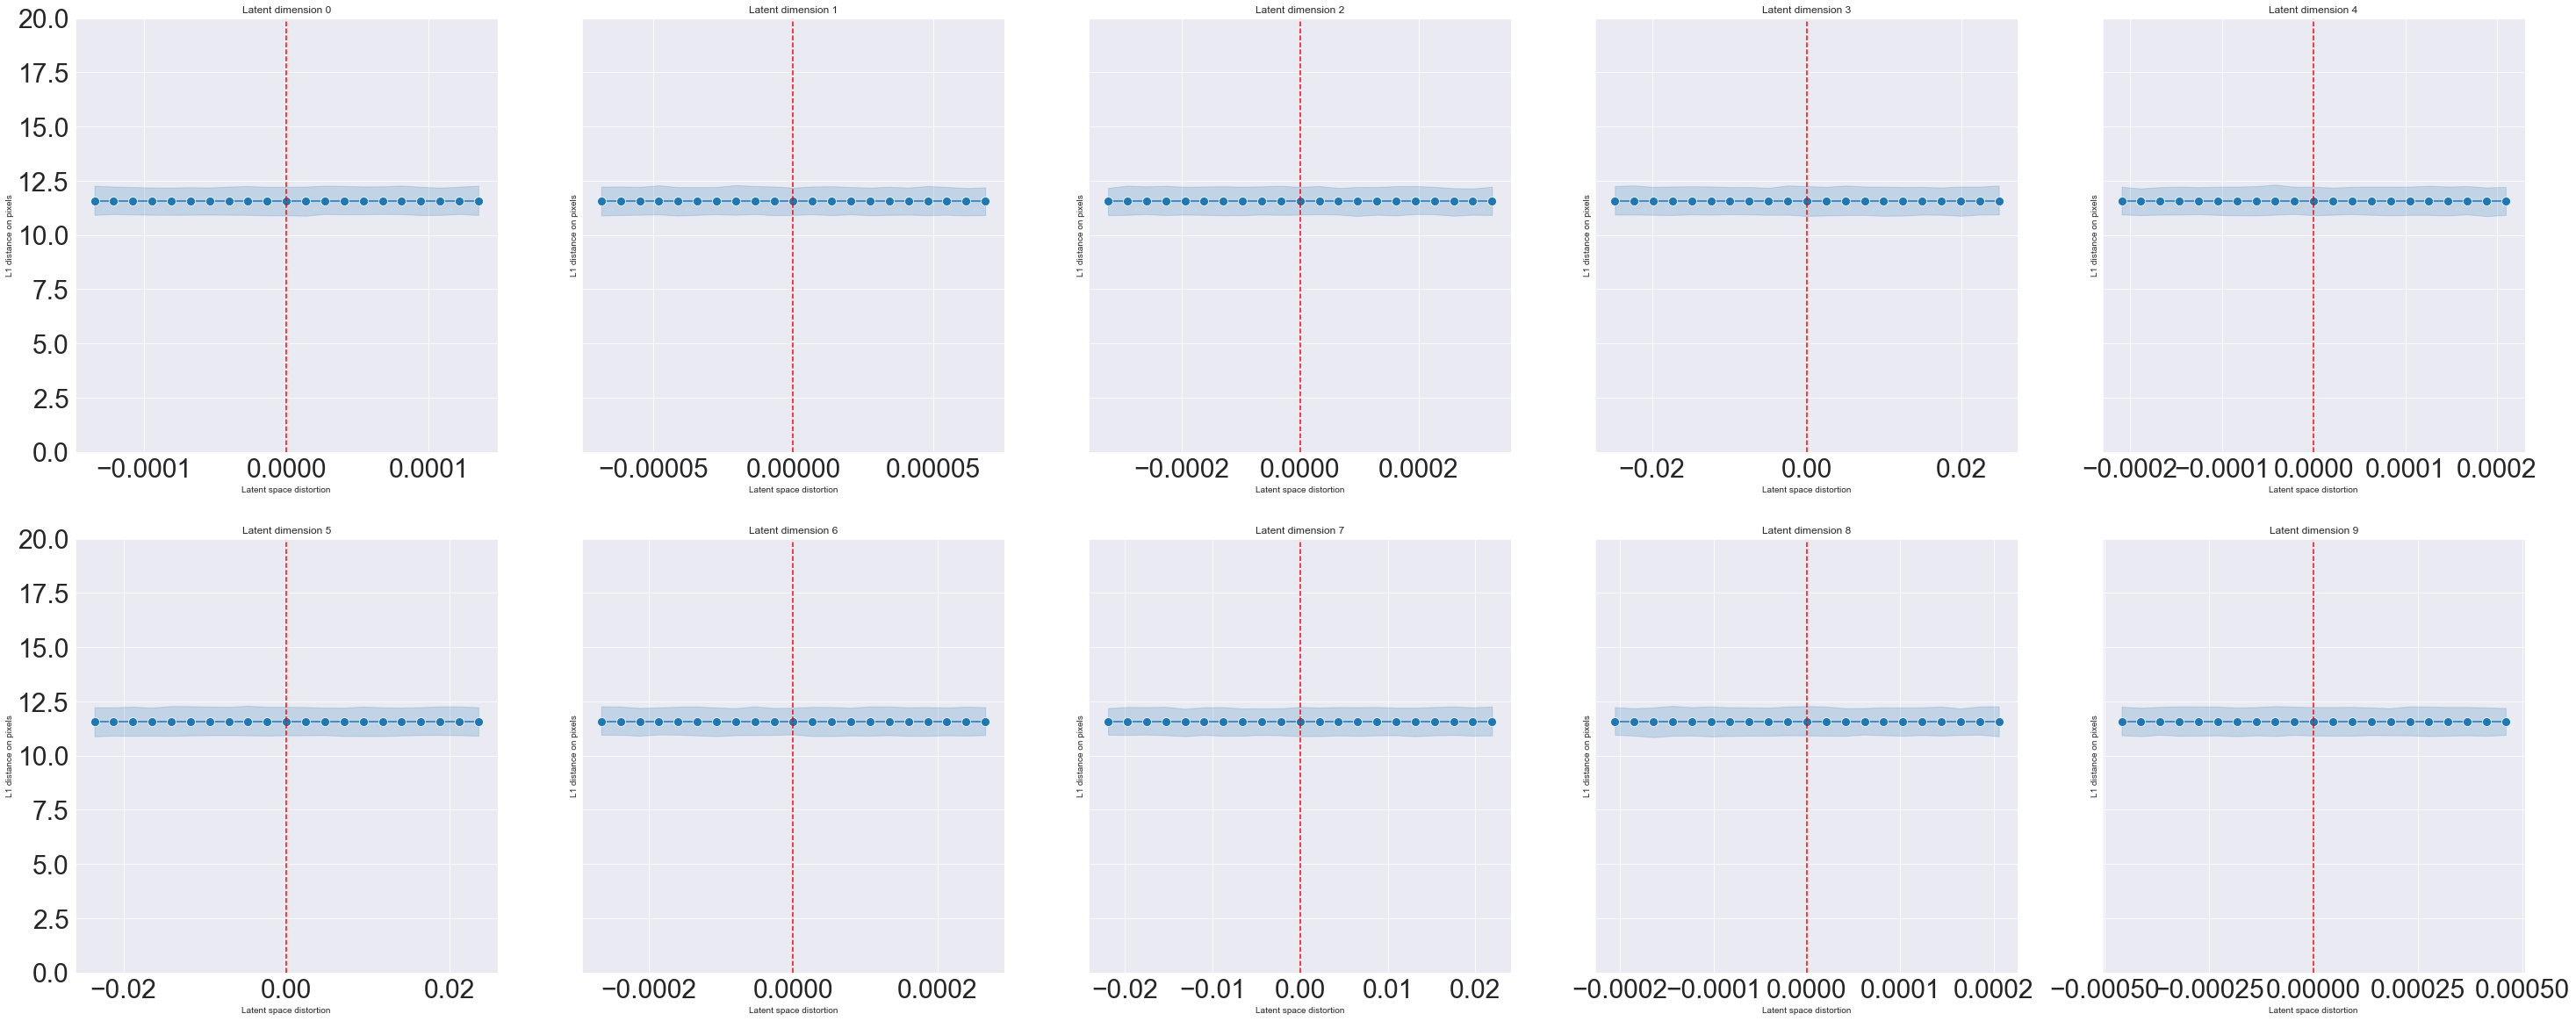

In [15]:
res = vecESAE_handler.plot_model(figsize=(50,20), nrows=2, ylim=20, font_scale=30)
fig = res['distortion']
fname = fig_path / "distortionVecESAE.png"
fig.savefig(fname)

In [19]:
vecVAE_handler = VectorModelHandler(model_name="VecVAE", model_version="standard", data="SynthVec", data_version="standard", verbose=False)

Loading VecVAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecVAE model loaded.


In [20]:
vecVAE_handler.load_checkpoint()

Loading latest checkpoint at logs\VecVAE\standard_SynthVec_standard\checkpoints\epoch=24-step=13627.ckpt .
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          10,100
         LeakyReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 77]           7,777
         LeakyReLU-4                   [-1, 77]               0
            Linear-5                   [-1, 55]           4,290
         LeakyReLU-6                   [-1, 55]               0

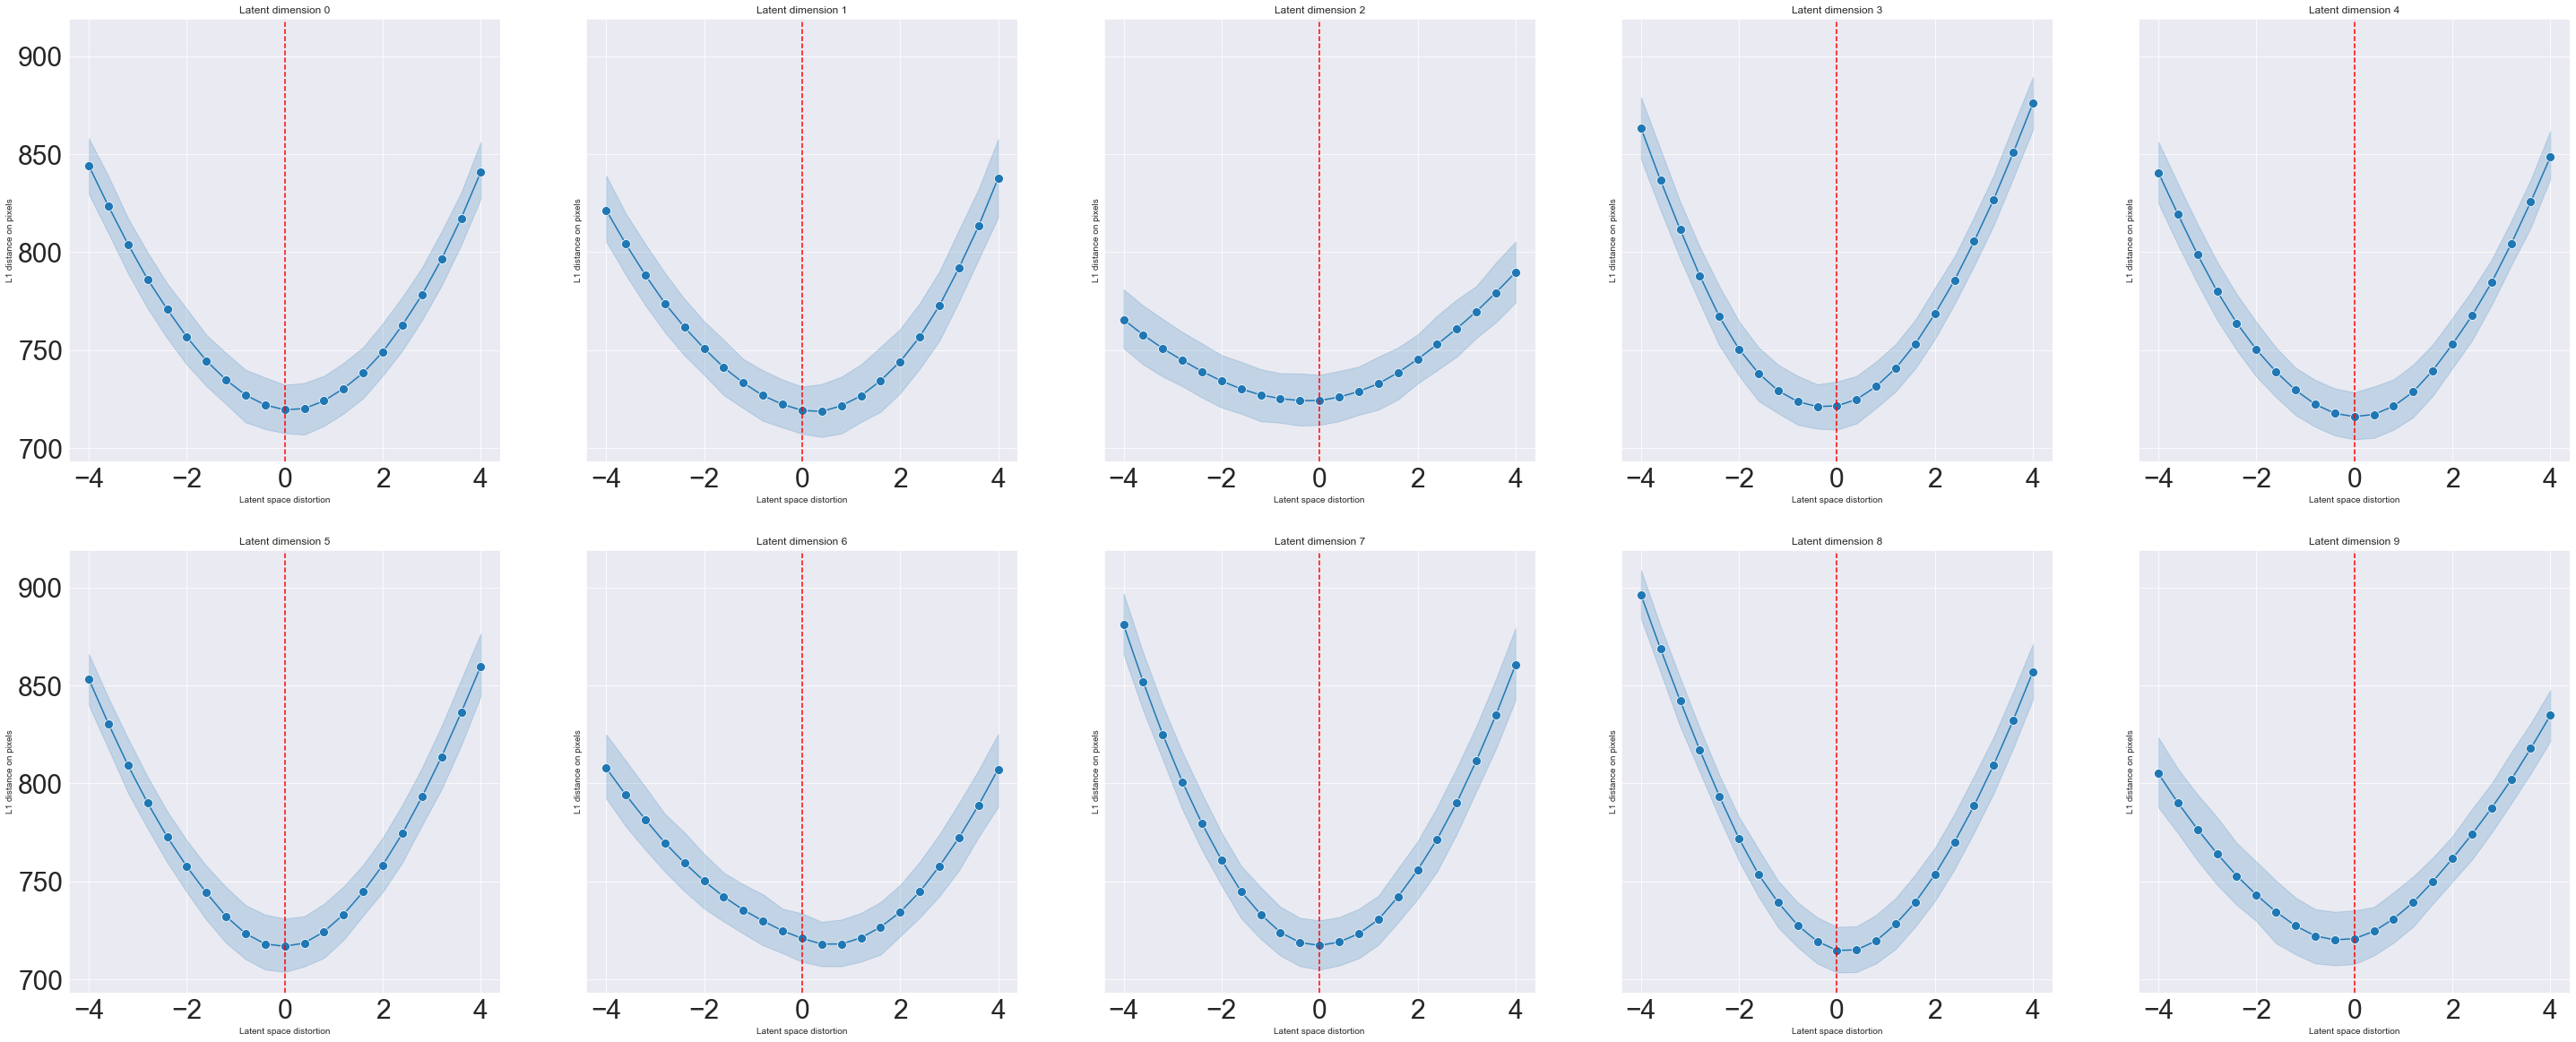

In [23]:
res = vecVAE_handler.plot_model(figsize=(50,20), nrows=2, font_scale=30)
fig = res['distortion']
fname = fig_path / "distortionVecVAE.png"
fig.savefig(fname)

---

In [21]:
model_names = ["SAE","ESAE","VAE"]
scores_df = pd.DataFrame()
scores_df["model_name"] = model_names
all_scores = []

In [22]:
scores = handler.score_model(FID=False, disentanglement=True, orthogonality=True,
                    save_scores=True, full=False)

Preparing the model for scoring orthogonality ...
Scoring orthogonality
RBF scoring
IMQ scoring
CAT scoring
dCov scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\dcor\_fast_dcov_avl.py:317: UserWarning: Falling back to uncompiled AVL fast distance covariance because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, A), array(float32, 1d, A), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(f"Falling back to uncompiled AVL fast distance "


Scoring model disentanglement.
DCI scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: invalid value encountered in true_divide
  S /= log(base)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: divide by zero encountered in log
  S /= log(base)
C:\Users\Giulia\Study\projects\research\SAE\metrics\DCI.py:172: RuntimeWarning: invalid value encountered in true_divide
  code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()


IRS scoring
MIG scoring
Modularity explicitness scoring


C:\Users\Giulia\Study\projects\research\SAE\metrics\ModExp.py:123: RuntimeWarning: invalid value encountered in true_divide
  delta = numerator / denominator
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


SAP scoring
Time elapsed for scoring 94


In [23]:
all_scores.append(scores)

In [24]:
scores = handlerESAE.score_model(FID=False, disentanglement=True, orthogonality=True,
                    save_scores=True, full=False)
all_scores.append(scores)

Preparing the model for scoring orthogonality ...
Scoring orthogonality
RBF scoring
IMQ scoring
CAT scoring
dCov scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\dcor\_fast_dcov_avl.py:317: UserWarning: Falling back to uncompiled AVL fast distance covariance because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, A), array(float32, 1d, A), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(f"Falling back to uncompiled AVL fast distance "


Scoring model disentanglement.
DCI scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: invalid value encountered in true_divide
  S /= log(base)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: divide by zero encountered in log
  S /= log(base)
C:\Users\Giulia\Study\projects\research\SAE\metrics\DCI.py:172: RuntimeWarning: invalid value encountered in true_divide
  code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()


IRS scoring
MIG scoring
Modularity explicitness scoring


C:\Users\Giulia\Study\projects\research\SAE\metrics\ModExp.py:123: RuntimeWarning: invalid value encountered in true_divide
  delta = numerator / denominator
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


SAP scoring
Time elapsed for scoring 89


In [25]:
scores = handlerVAE.score_model(FID=False, disentanglement=True, orthogonality=True,
                    save_scores=True, full=False)
all_scores.append(scores)

Preparing the model for scoring orthogonality ...
Scoring orthogonality
RBF scoring
IMQ scoring
CAT scoring
dCov scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\dcor\_fast_dcov_avl.py:317: UserWarning: Falling back to uncompiled AVL fast distance covariance because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, A), array(float32, 1d, A), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(f"Falling back to uncompiled AVL fast distance "


Scoring model disentanglement.
DCI scoring


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: invalid value encountered in true_divide
  S /= log(base)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2625: RuntimeWarning: divide by zero encountered in log
  S /= log(base)
C:\Users\Giulia\Study\projects\research\SAE\metrics\DCI.py:172: RuntimeWarning: invalid value encountered in true_divide
  code_importance = importance_matrix.sum(axis=1) / importance_matrix.sum()


IRS scoring
MIG scoring
Modularity explicitness scoring


C:\Users\Giulia\Study\projects\research\SAE\metrics\ModExp.py:123: RuntimeWarning: invalid value encountered in true_divide
  delta = numerator / denominator
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


SAP scoring
Time elapsed for scoring 121


In [26]:
for i,score_set in enumerate(all_scores): 
    for k,v in score_set.items():
        scores_df.loc[i,k] = v

In [27]:
scores_df

,model_name,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP
0,SAE,0.003366,0.026879,-32.804668,0.229434,NaN,0.680345,0.032560,NaN,0.002
1,ESAE,0.004271,0.028948,-41.469337,0.292190,NaN,0.492522,0.019467,NaN,0.024
2,VAE,0.001465,0.010816,-147.206253,0.140675,NaN,0.410131,0.013262,NaN,0.012


## Collecting scores for synthetic vector dataset experiments

In [28]:
#load all scores and save them in lists 
#extract relevan numbers from the lists and form a df
# plot df with seaborn
data_versions = ["standard","discrete","continuous","big"]
model_names = ["VecESAE","VecSAE","VecVAE"]

In [40]:
handlers=[]
for data_v in data_versions:
    for model_n in model_names: 
        handler = (VectorModelHandler(model_name=model_n, model_version="standard", 
                                           data="SynthVec", data_version=data_v, verbose=False))
        handlers.append(handler)

Loading VecESAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecESAE model loaded.
Loading VecSAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
----------Opening SynthVec dataset version standard / test----------
Files already there. Proceed to reading.
Loading generated data.
Loading metadata
Reading quantiles file
Dataset loaded.
VecSAE model loaded.
Loading VecVAE
--------------------
----------Opening SynthVec dataset version standard / train----------
Files already th

In [41]:
scores_df = pd.DataFrame()

In [42]:
scores_df["model_name"] = model_names*len(data_versions)
scores_df["data_version"] = [item for data_v in data_versions for item in [data_v]*len(model_names)]

In [43]:
scores = [handler.load_scores(name="scoring") for handler in handlers]

# - to go 
#scores = [handlers[3].load_scores()]
#scores[0]["extra_disentanglement"]=None

In [44]:
scores[0]

{'RBF': 0.015189409255981445,
 'IMQ': 0.04211711883544922,
 'CAT': -0.1615293025970459,
 'dCOV': 0.0004448918977173883,
 'DCI': 0.022975431934453228,
 'IRS': 0.6610408347408944,
 'MIG': 0.027064272688382594,
 'ModExp': 0.3066816420810107,
 'SAP': 0.0007999999999999993}

In [45]:
for i,score_set in enumerate(scores): 
    for k,v in score_set.items():
        scores_df.loc[i,k] = v

In [ ]:
# random fill - useful to test visualisations
#for k,v in scores[0].items():
#    scores_df.loc[:,k] = np.random.randn(12)**2
#scores_df = scores_df.drop("extra_disentanglement", axis=1)

In [46]:
scores_df

,model_name,data_version,RBF,IMQ,CAT,dCOV,DCI,IRS,MIG,ModExp,SAP
0,VecESAE,standard,0.015189,0.042117,-0.161529,0.000445,0.022975,0.661041,0.027064,0.306682,0.000800
1,VecSAE,standard,0.026888,0.069378,-802.112671,5.240126,0.005647,0.674220,0.005635,0.430792,0.011800
2,VecVAE,standard,0.001399,0.010498,-127.531487,0.141176,0.000990,0.350142,0.002403,0.290196,0.007000
3,VecESAE,discrete,0.022906,0.057015,-0.446848,0.001741,0.017003,0.562547,0.017709,0.600752,0.003200
4,VecSAE,discrete,0.024454,0.033591,-1294.276245,4.202439,0.015070,0.625581,0.028266,0.617612,0.026800
5,VecVAE,discrete,0.001554,0.010958,-131.270096,0.142695,0.001734,0.370357,0.002599,0.653227,0.007800
6,VecESAE,continuous,0.009773,0.025878,-1.281475,0.006464,0.038372,0.831236,0.008693,0.585250,0.010667
7,VecSAE,continuous,0.003799,0.012843,-4008.612305,10.538882,0.005245,0.893096,0.001633,0.691180,0.016667
8,VecVAE,continuous,0.001347,0.010366,-129.345398,0.141924,0.005222,0.389475,0.005156,0.368557,0.007333
9,VecESAE,big,0.015315,0.041043,-20.298193,0.069307,0.009026,0.779077,0.009870,0.419960,0.011800


## Visualisations of model scores

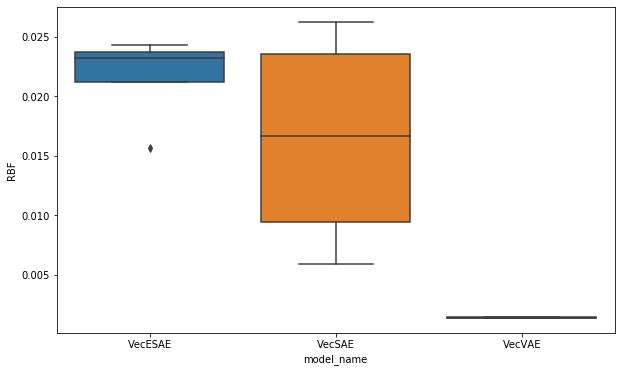

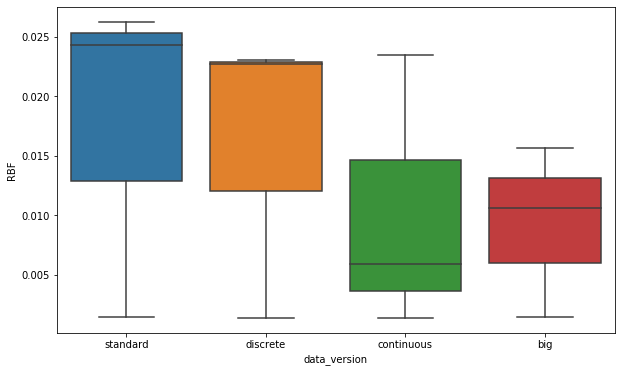

In [18]:
# finally visualising 
plt.figure(figsize=(10,6))
sns.boxplot(x='model_name',y='RBF',data=scores_df)
# finally visualising 
plt.figure(figsize=(10,6))
sns.boxplot(x='data_version',y='RBF',data=scores_df)


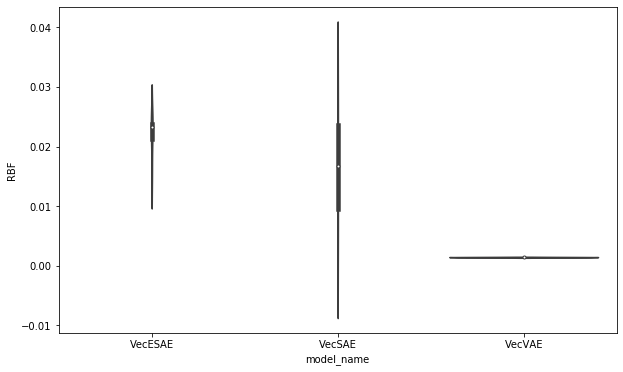

In [19]:
plt.figure(figsize=(10,6))
sns.violinplot(x='model_name',y='RBF',data=scores_df, split=True)
#sns.swarmplot(x='model_name',y='RBF',data=scores_df, split=True, color="white")

In [20]:
scores_df.columns[2:5]

Index(['RBF', 'IMQ', 'CAT'], dtype='object')

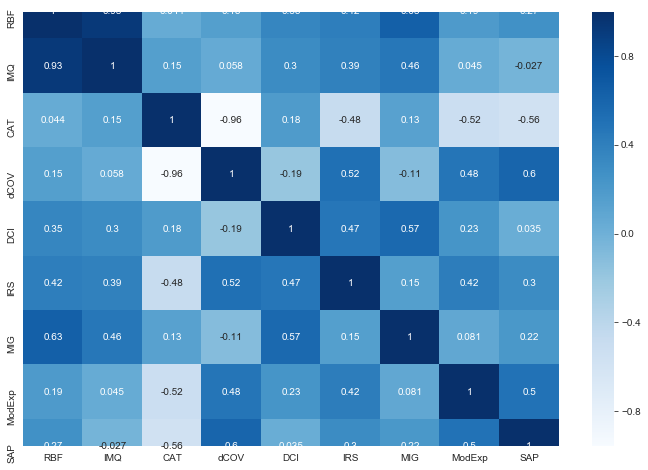

In [49]:
plt.figure(figsize=(12,8))

scores_corr = scores_df.corr()
sns.heatmap(scores_corr, annot=True, cmap='Blues')


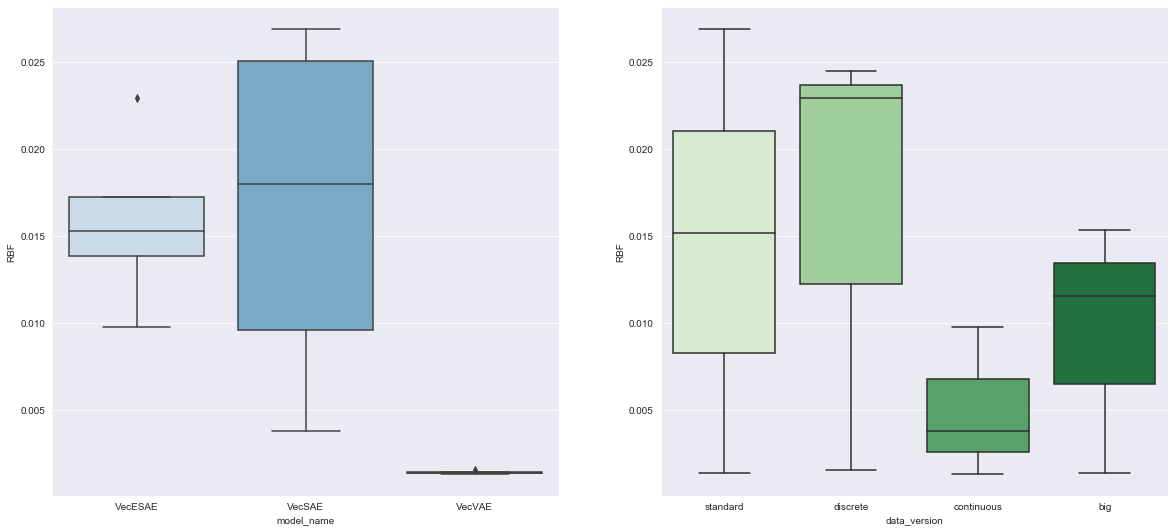

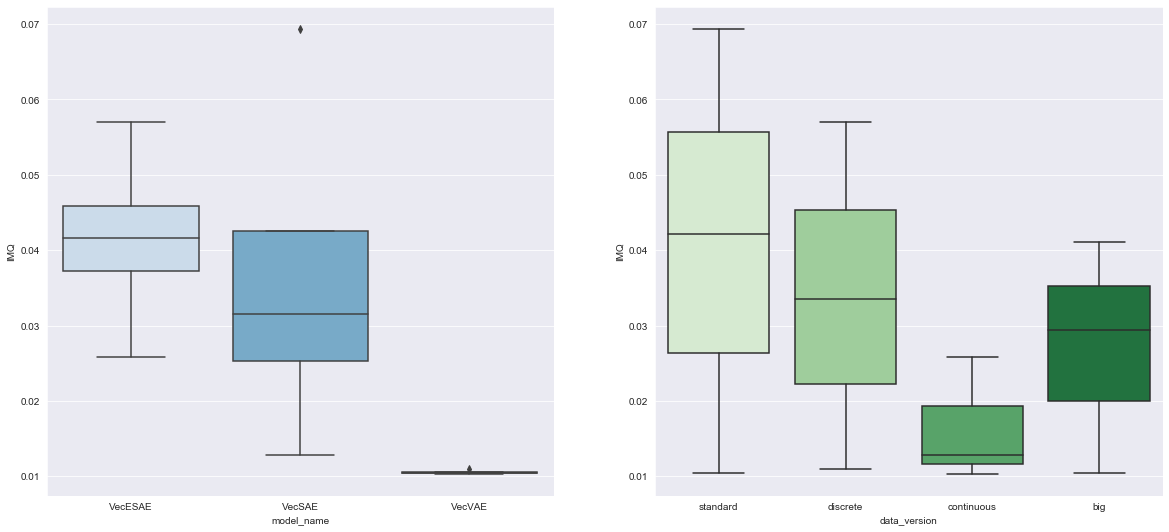

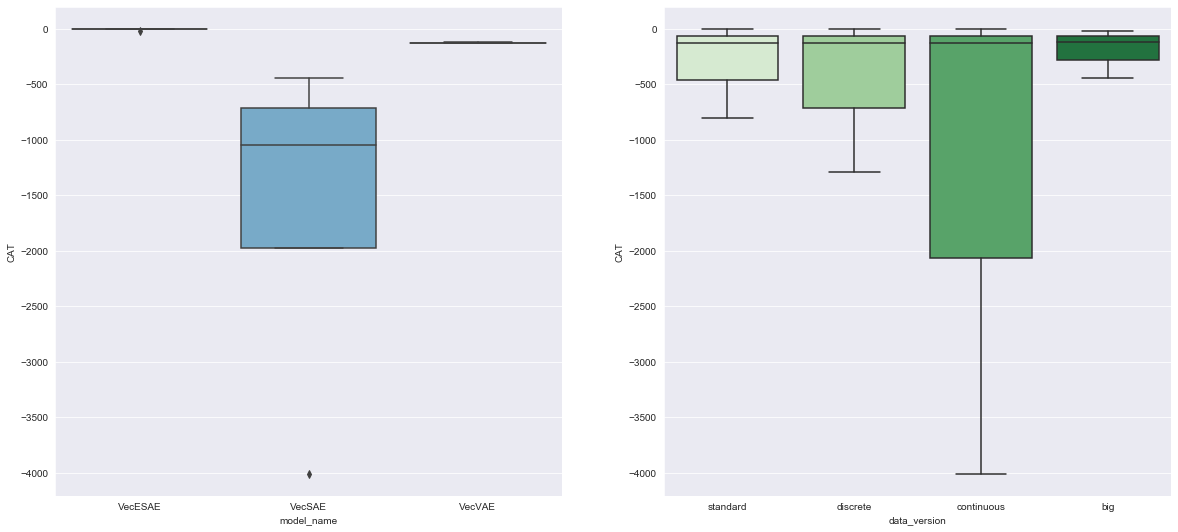

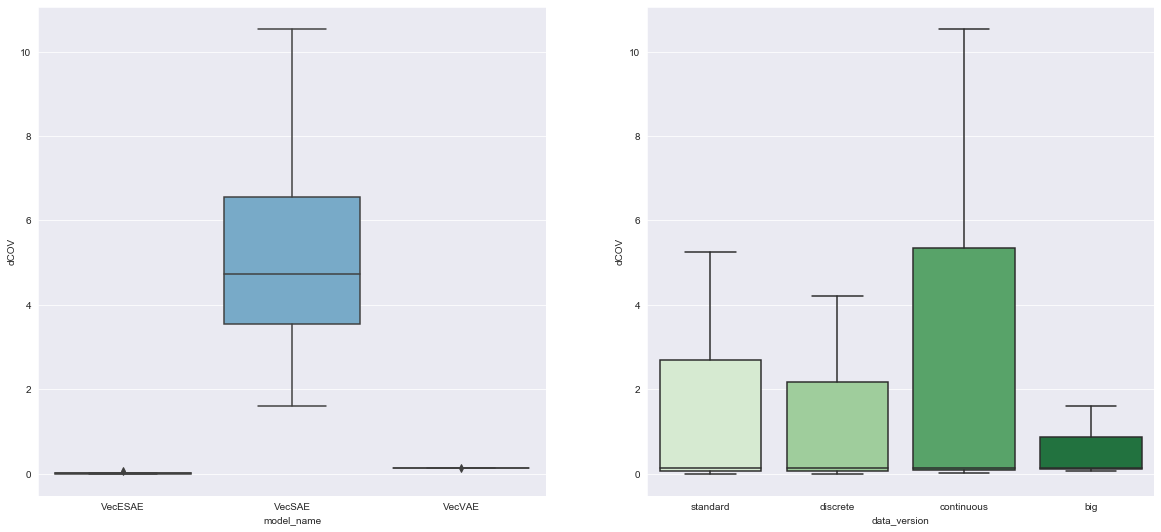

In [48]:
for k in scores_df.columns[2:6]: # orthogonality
    fig, axs = plt.subplots(ncols=2, figsize=(20,9))
    sns.boxplot(x='model_name',y=k,data=scores_df, ax=axs[0], palette="Blues")
    sns.boxplot(x='data_version',y=k,data=scores_df, ax=axs[1], palette="Greens")

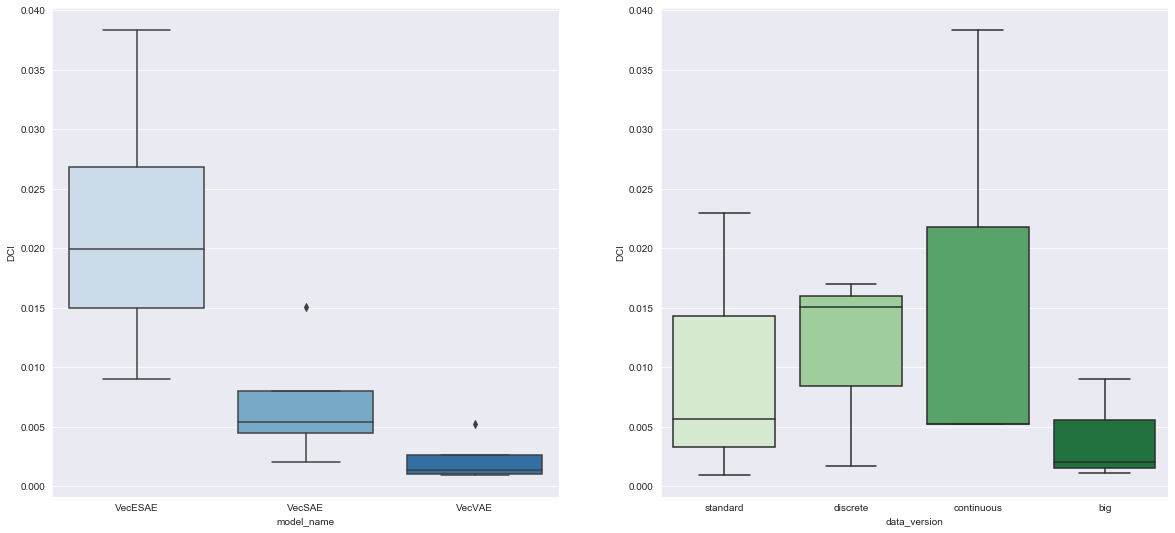

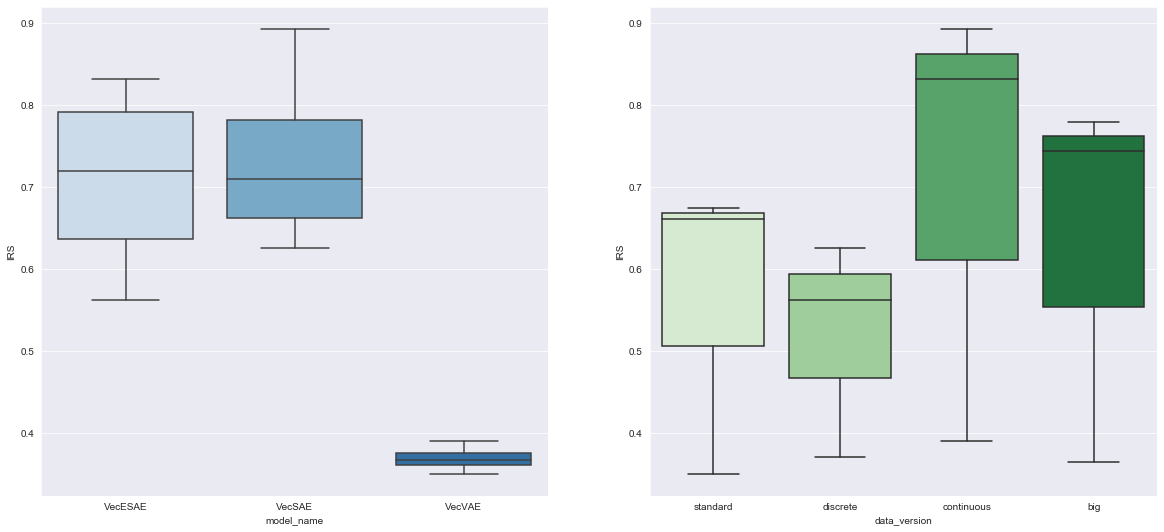

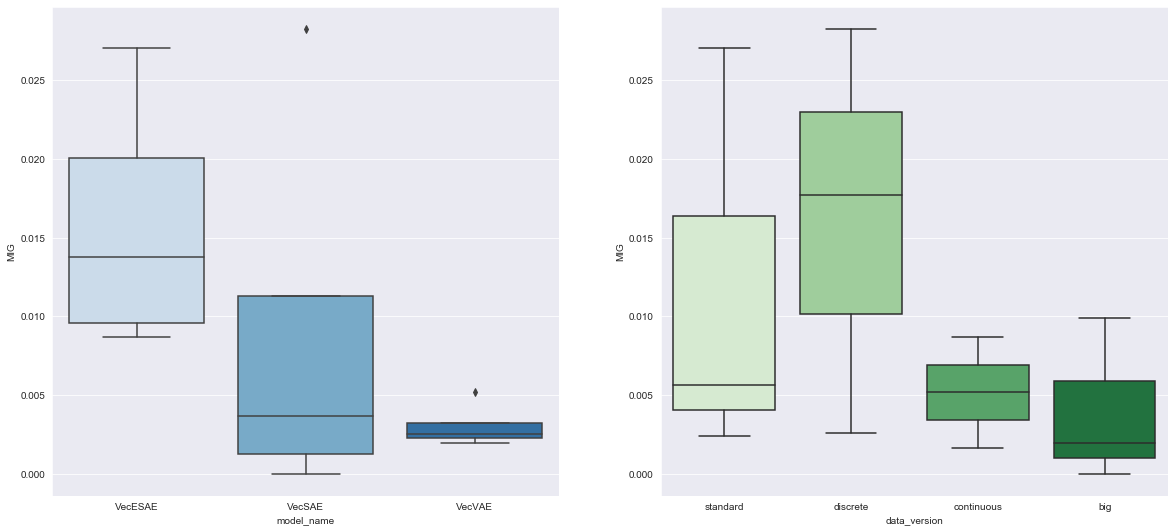

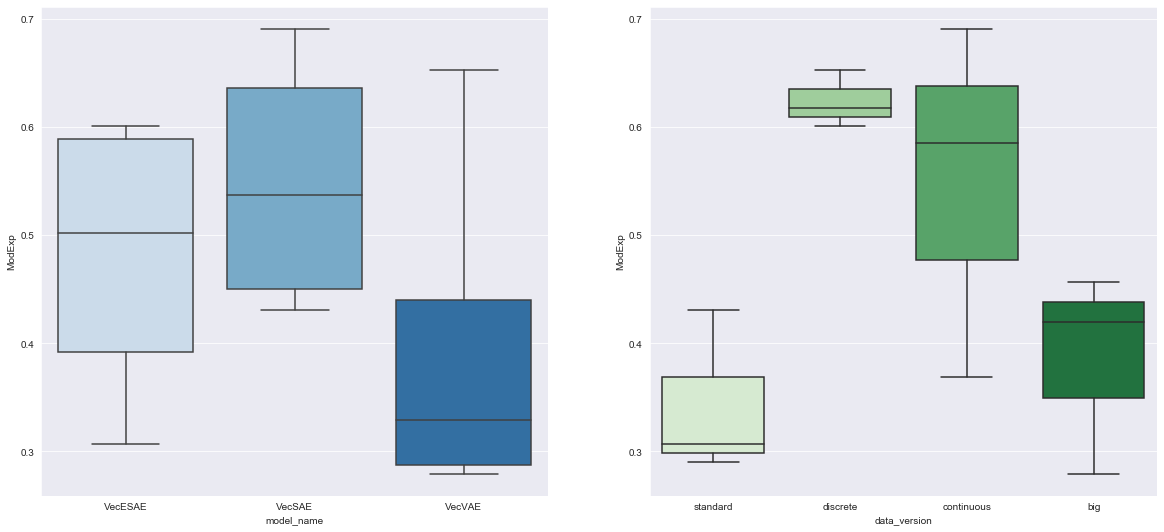

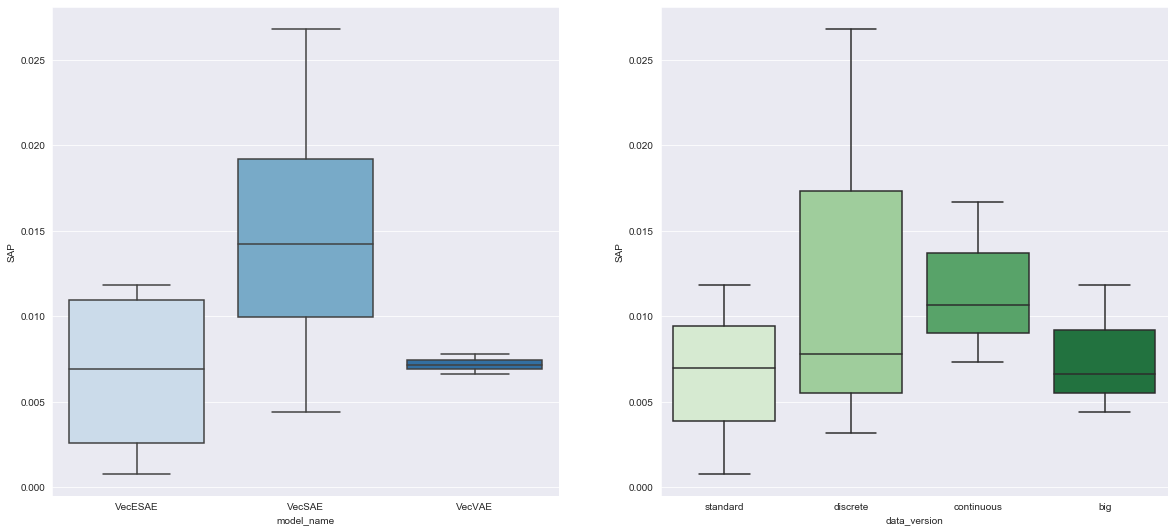

In [51]:
# finally visualising 
for k in scores_df.columns[6:]: # disentanglement
    fig, axs = plt.subplots(ncols=2, figsize=(20,9))
    sns.boxplot(x='model_name',y=k,data=scores_df, ax=axs[0], palette="Blues")
    sns.boxplot(x='data_version',y=k,data=scores_df, ax=axs[1], palette="Greens")